<a href="https://colab.research.google.com/github/raslene5/FFDS-backend/blob/main/Copie_de_Ready_v_Financial_Fraud_Detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the data**

In [1]:
from google.colab import files
files.upload()  # This will prompt to upload `kaggle.json`


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"raslenb","key":"b089874f114ea30d5d5d6765288db8f5"}'}

In [2]:
import os
import shutil
os.rename("kaggle (2).json", "kaggle.json")

# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the correct directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set the permissions to prevent permission errors
os.chmod("/root/.kaggle/kaggle.json", 600)


In [3]:
!pip install kaggle


In [4]:
!kaggle datasets download -d ealaxi/paysim1


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 84% 150M/178M [00:00<00:00, 388MB/s] 
100% 178M/178M [00:00<00:00, 430MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("paysim1.zip", 'r') as zip_ref:
    zip_ref.extractall("paysim1")  # Extracts into a folder named 'paysim1'

# List extracted files
os.listdir("paysim1")


['PS_20174392719_1491204439457_log.csv']

# **This is a sample of 1 row with headers explanation:**



**1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0**

◼**step** : maps a unit of time in the real world. In
this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

◼**type** : CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

◼**amount** : amount of the transaction in local currency.

◼**nameOrig** : customer who started the transaction

◼**oldbalanceOrg** : initial balance before the transaction

◼**newbalanceOrig** : new balance after the transaction

◼ **nameDest** : customer who is the recipient of the transaction

◼ **oldbalanceDest** : initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

◼ **newbalanceDest** : new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

◼ **isFraud** : This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

◼ **isFlaggedFraud** : The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.





# **Business Objective: Financial fraud detection system via data analysis (AI fraud detection system)**

*   **Problem statement**                                                      
Financial fraud continues to pose a major threat in the financial industry.                                                                   Fraudulent transactions inflict significant financial losses and affect both businesses and customers.Traditional rule-based fraud detection approaches don't scale well, resulting in large false positive rates and missing fraudulent actions.

*   Our goal is to build a hybrid automated fraud detection system that can:

* ✅   reduce financial losses through minimizing missed cases.
* ✅ accurately identify fraudulent transactions in real-time
* ✅ educe false positives to prevent unnecessary transaction blocks.


*   **Business Impact**                                                                        
  A well-optimized fraud detection model will:
* ✔  Improve the customer experience through reducing false fraud warnings.
* ✔  Avoid financial losses by flagging fraudulent transactions.
* ✔ Improve security and compliance with regulatory regulations.

* ⭕ A strong fraud detection system is about more than just discovering fraud; it's also about reducing risk while providing a flawless transaction experience for  legitimate users.




















# **import librairies**

In [6]:
# ====================================
# 📦 Data Manipulation & Analysis
# ====================================
import pandas as pd
import numpy as np
import re

# ====================================
# 📊 Visualization
# ====================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter

# ====================================
# ⚙️ Preprocessing & Feature Engineering
# ====================================
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split

# ====================================
# ⚖️ Handling Imbalanced Data
# ====================================
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

# ====================================
# 🤖 Machine Learning Models & Evaluation
# ====================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# ====================================
# 🔥 Gradient Boosting (XGBoost)
# ====================================
import xgboost as xgb
from xgboost import plot_importance

# ====================================
# 🧠 Deep Learning (TensorFlow / Keras)
# ====================================
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization,
    Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dropout, SpatialDropout1D, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ====================================
# 💾 Model Persistence
# ====================================
import joblib


# **Load the dataset**

In [7]:
df = pd.read_csv("paysim1/PS_20174392719_1491204439457_log.csv")

# **Data exploration**

In [8]:
df.shape

(6362620, 11)

In [9]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# Check for null values

In [12]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# Check for duplicates

In [13]:
df.duplicated().sum()

np.int64(0)

# Check unique values

In [14]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

# **Exploratory Data Analysis:**


# Distribution of the transaction types

<ipython-input-15-10fd775cea87>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=transaction_counts.index, y=transaction_counts.values, palette="viridis")


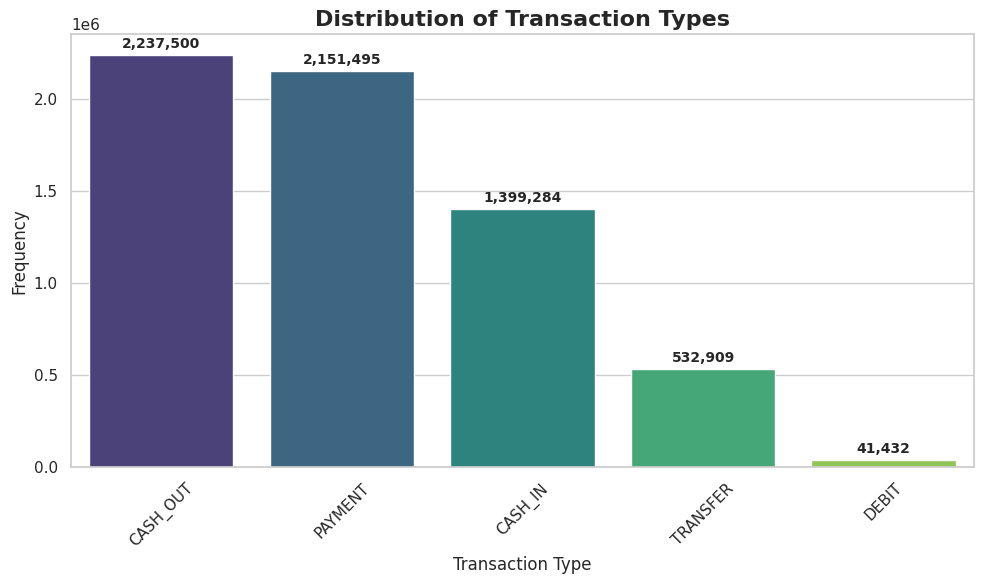

In [15]:
# Set a visually appealing style
sns.set(style="whitegrid")

# Count the occurrences of each transaction type
transaction_counts = df['type'].value_counts().sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=transaction_counts.index, y=transaction_counts.values, palette="viridis")

# Add value labels above bars
for i, v in enumerate(transaction_counts.values):
    ax.text(i, v + max(transaction_counts.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Transaction Types", fontsize=16, fontweight='bold')
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Fraud cases by transaction type

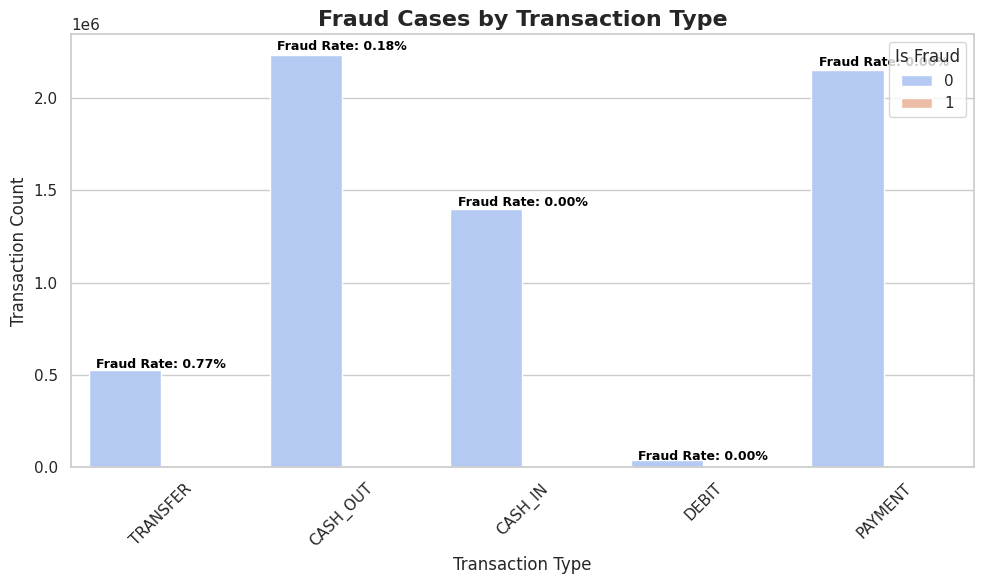

In [16]:
# Set visual style
sns.set(style="whitegrid")

# Calculate fraud rate per transaction type
fraud_rate = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
ordered_types = fraud_rate.index

# Create the count plot with hue for fraud cases
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x="type",
    data=df,
    hue="isFraud",
    palette="coolwarm",  # Using a better contrasting palette
    order=ordered_types
)

# Titles and labels
plt.title("Fraud Cases by Transaction Type", fontsize=16, fontweight='bold')
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.xticks(rotation=45)

# Add fraud rate annotations above bars
total_counts = df['type'].value_counts()
for i, t in enumerate(ordered_types):
    rate = fraud_rate[t]
    total = total_counts[t]
    ax.text(i, total + total * 0.01, f"Fraud Rate: {rate:.2%}", ha='center', fontsize=9, fontweight='bold', color='black')

plt.tight_layout()
plt.legend(title="Is Fraud", loc="upper right")
plt.show()

🔔 it's clear that the fraud rates appear to be extremely low across all transaction categories,with the highest fraud rate for TRANSFER.This indicates that fraud is quite infrequent across all transaction types, but TRANSFER may be more vulnerable to fraudulent activities than others.                       
        Given the very low fraud rates, this suggests a severely imbalanced dataset, which is common in fraud detection problems.                  This will require techniques such as oversampling or anomaly detection  during model training to accurately identify fraudulent transactions.

# Distribution of the transaction amounts

<ipython-input-17-743ed4e0033a>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['isFraud'] == 0]['amount'], label="Non-Fraudulent", shade=True, color="blue", alpha=0.6, linewidth=2)
<ipython-input-17-743ed4e0033a>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['isFraud'] == 1]['amount'], label="Fraudulent", shade=True, color="red", alpha=0.6, linewidth=2)


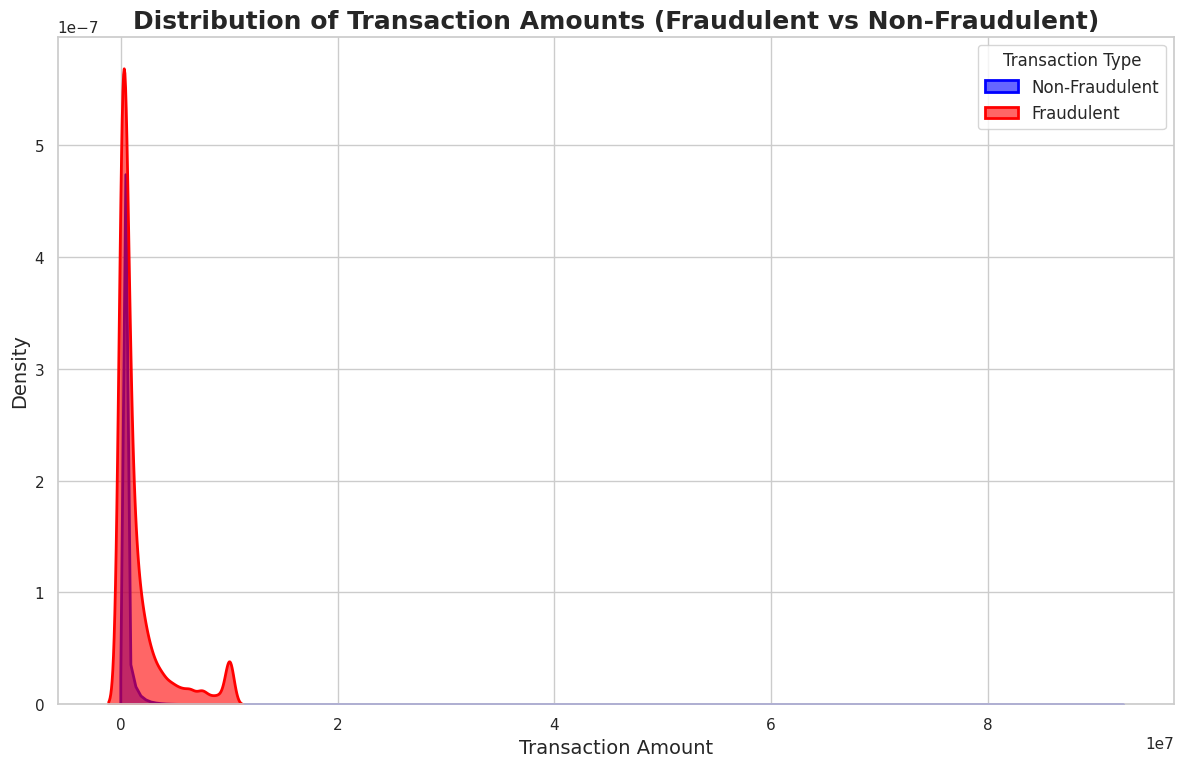

In [17]:
# Plotting the distribution of transaction amounts for fraudulent vs non-fraudulent transactions
plt.figure(figsize=(12, 8))

# KDE plot for non-fraudulent transactions
sns.kdeplot(df[df['isFraud'] == 0]['amount'], label="Non-Fraudulent", shade=True, color="blue", alpha=0.6, linewidth=2)

# KDE plot for fraudulent transactions
sns.kdeplot(df[df['isFraud'] == 1]['amount'], label="Fraudulent", shade=True, color="red", alpha=0.6, linewidth=2)

# Adding titles and labels
plt.title("Distribution of Transaction Amounts (Fraudulent vs Non-Fraudulent)", fontsize=18, fontweight='bold')
plt.xlabel("Transaction Amount", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Adding a legend
plt.legend(title="Transaction Type", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

🔔 As we can see Fraudulent transactions have significantly higher amounts than non-fraudulent ones.                                                          
       The distribution of non-fraudulent transactions is highly skewed due to the presence of some extremely large transactions.
          Fraudulent transactions have higher values, indicating that fraudsters focus on much larger transactions.

<ipython-input-18-c922a209a8e2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='amount', data=df[df.amount < 1e5], palette='Set2')


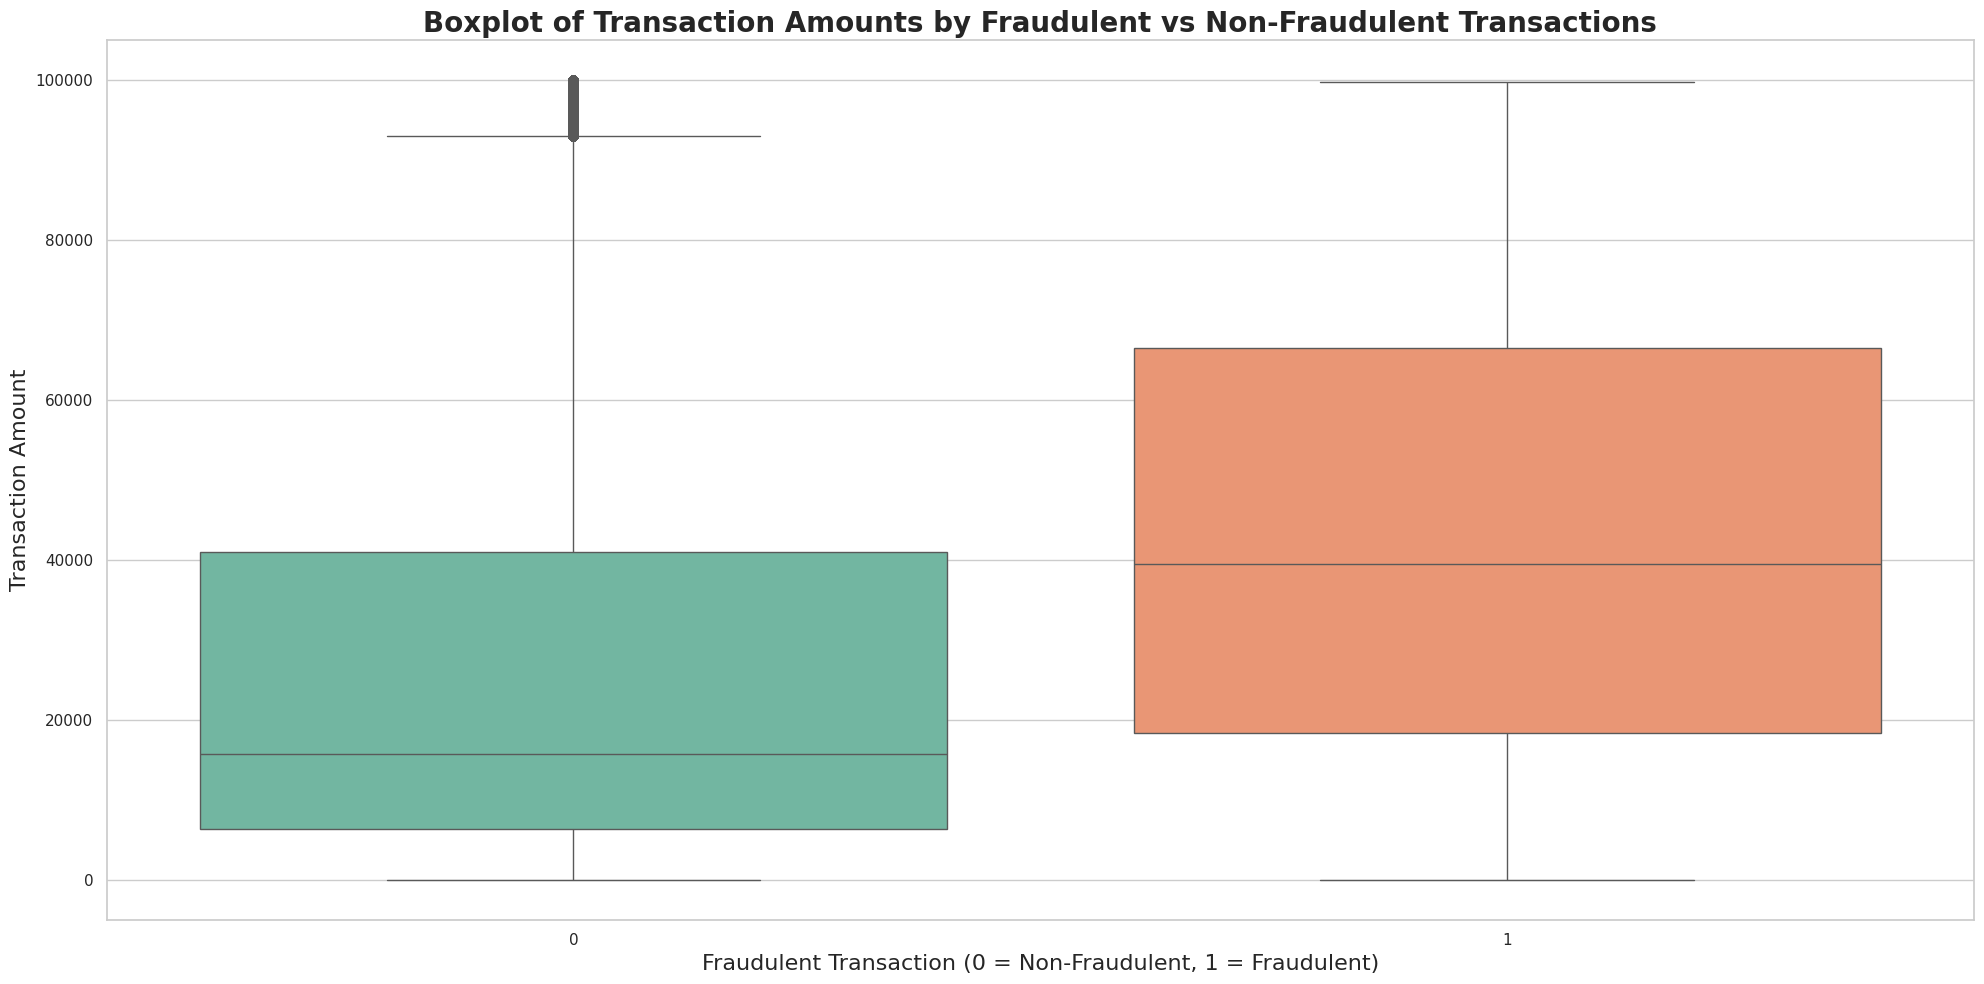

In [18]:
# Boxplot for 'amount' vs 'isFraud' (filtered for amount less than 100k)
plt.figure(figsize=(20, 10))

# Creating the boxplot
sns.boxplot(x='isFraud', y='amount', data=df[df.amount < 1e5], palette='Set2')

# Adding titles and labels
plt.title('Boxplot of Transaction Amounts by Fraudulent vs Non-Fraudulent Transactions', fontsize=20, fontweight='bold')
plt.xlabel('Fraudulent Transaction (0 = Non-Fraudulent, 1 = Fraudulent)', fontsize=16)
plt.ylabel('Transaction Amount', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


Our 'amount' variable represents the amount of each transaction, we notice that there are very high amounts, but that most very minor amounts, which makes us notice the presence of atypical values ​​in our boxloot graph.

We are going to analyze it,in order to see if it is feasible to be able to carry out the treatment of these atypical values, with the purpose of not losing much value.

In [19]:
df_isFraud = df[(df['isFraud'] == 1)]
df_isFraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


# Number of fraudulent transactions per day

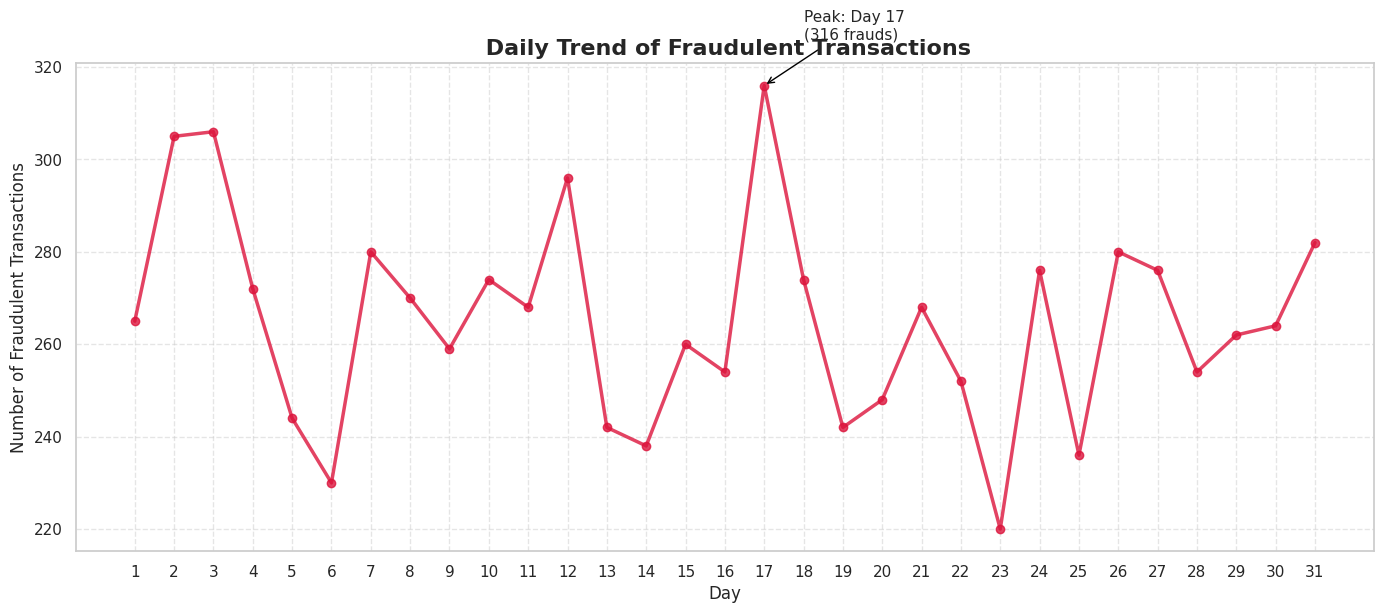

In [20]:
# Create a new column representing the day (each 24-hour period)
df['day'] = df['step'] // 24 + 1

# Count fraudulent transactions per day
fraud_per_day = df[df['isFraud'] == 1].groupby('day').size()

# Plot the trend of fraudulent transactions
plt.figure(figsize=(14, 6))
plt.plot(fraud_per_day.index, fraud_per_day.values,
         color='crimson', linewidth=2.5, marker='o', linestyle='-', alpha=0.8)

plt.title(" Daily Trend of Fraudulent Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Number of Fraudulent Transactions", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(ticks=range(fraud_per_day.index.min(), fraud_per_day.index.max() + 1))
plt.tight_layout()

# Optional: Annotate the day with the highest fraud count
max_day = fraud_per_day.idxmax()
max_val = fraud_per_day.max()
plt.annotate(f'Peak: Day {max_day}\n({max_val} frauds)',
             xy=(max_day, max_val),
             xytext=(max_day+1, max_val+10),
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=11, backgroundcolor='white')

plt.show()


From this graph we observe two types of fraud levels:

Consistent Fraud Levels: Fraudulent transaction counts remain steady over time, showing consistent fraud activity with little daily changes.

Uniform Fraud Distribution: The absence of severe peaks or declines indicates that fraudulent activity is evenly distributed, likely representing realistic, ongoing fraud attempts rather than an event-based increase.

<ipython-input-21-3cc76441e876>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


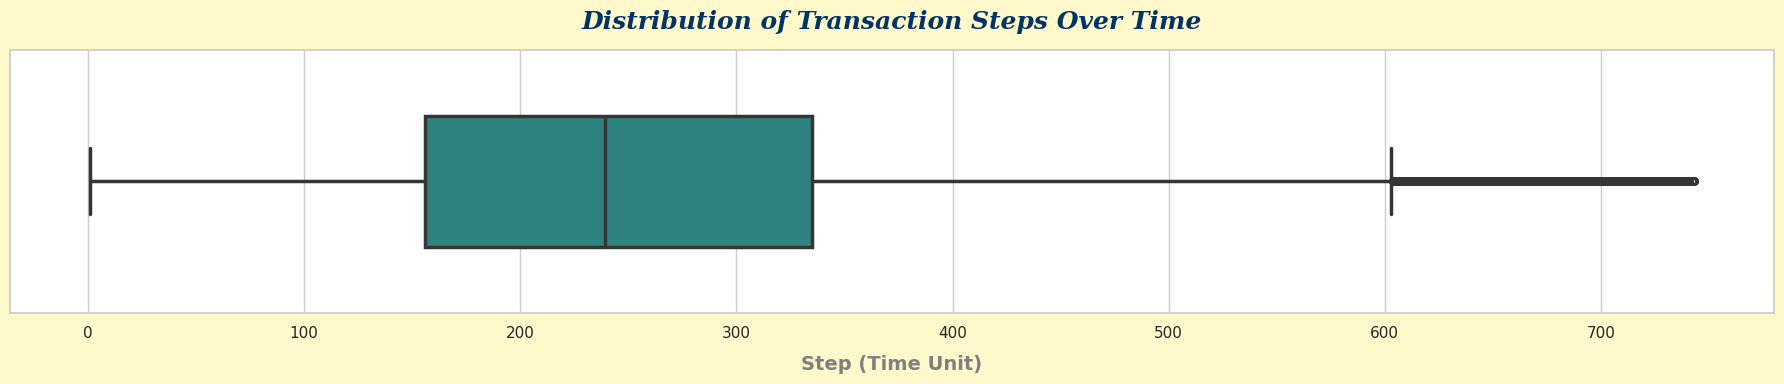

In [21]:
# Set up the figure size and style
plt.figure(figsize=(18, 4))
sns.set(style='whitegrid')

# Create the boxplot
sns.boxplot(
    x='step',
    data=df,
    orient='h',
    palette='viridis',
    width=0.5,
    fliersize=5,  # size of outliers
    linewidth=2.5  # thickness of box lines
)

# Customize background color
plt.gcf().set_facecolor('#fff9cc')  # soft yellow-beige

# Customize title with advanced font styling
plt.title(
    'Distribution of Transaction Steps Over Time',
    pad=15,
    fontsize=18,
    fontweight='bold',
    fontstyle='italic',
    color='#003366',
    fontname='DejaVu Serif'
)

# Remove x-axis label clutter for elegance
plt.xlabel('Step (Time Unit)', fontsize=14, weight='bold', labelpad=10, color='gray')

# Tidy y-axis
plt.yticks([])

# Extra margin for clarity
plt.tight_layout()

# Display
plt.show()


While we notice that in the variable 'Step', we have the presence of outliers, we cannot handle their imputation because it is an indicator of time in progression.

We are even evaluating the possibility of dispensing with this variable since we have managed to create new variables from this

# Analysis of isFlaggedFraud

In [22]:
df[(df['isFlaggedFraud'] == 1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,9
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,11
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,12
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,17
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,18
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1,18
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1,24
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1,25
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1,26
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1,27


In [23]:
fraudby_type = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
flaggedFraudby_type = df[df['isFlaggedFraud']==1].groupby('type')['isFlaggedFraud'].count()

In [24]:
print(f'Fraud per transaction type: \n{fraudby_type}\n \nFlagged fraud per transaction type: \n{flaggedFraudby_type}')

Fraud per transaction type: 
isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097
 
Flagged fraud per transaction type: 
type
TRANSFER    16
Name: isFlaggedFraud, dtype: int64


If we investigates the variable isFlaggedFraud, an interesting pattern emerges. All the variables has oldbalanceDest and newbalanceDest set to zero among the dataset's 16 records.

  It's also worth noting that only TRANSFER transactions have the isFlaggedFraud variable set to one, which means that when a transaction above $200k, the system flags it as fraudulent as a precaution.
                                                    
  'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash.

  Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs.
  
  These observations appear, at first, to bear out the description provided on Kaggle for the modus operandi of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out.

In [25]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


❗It turns out that the origin of isFlaggedFraud is unclear, contrary to the description supplied.The 16 entries (out of 6 million) with the isFlaggedFraud a feature do not appear to correlate with any explanatory variable.

The data is reported as isFlaggedFraud being set while attempting to 'TRANSFER' an 'amount' larger than 200,000. In fact, as demonstrated above, isFlaggedFraud can stay unset even when this condition is met.

In [26]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest = 0 and\
 newbalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)])))


The number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest = 0 and newbalanceDest = 0: 4158


⛔Can oldBalanceDest and newBalanceDest indicate whether isFlaggedFraud is set?

For each TRANSFER with isFlaggedFraud set, the old and new balances in the origin and destination accounts are identical.This is apparently due to the transaction being halted.Interestingly, in all such transactions, oldBalanceDest equals zero.

However, as shown above, because isFlaggedFraud can stay unset in TRANSFERS and both oldBalanceDest and newBalanceDest can be 0, these requirements do not determine the status of isFlaggedFraud.

In [27]:
print('\nMin, Max of oldbalanceOrg for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldbalanceOrg.min()), round(dfFlagged.oldbalanceOrg.max())]))

print('\nMin, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where \
oldbalanceOrg = \
newbalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
== dfTransfer.newbalanceOrig)].oldbalanceOrg.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
               == dfTransfer.newbalanceOrig)].oldbalanceOrg.max())]))


Min, Max of oldbalanceOrg for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where oldbalanceOrg = newbalanceOrig: [0.0, 575668]


isFlaggedFraud cannot be thresholded on oldBalanceOrig because the corresponding range of values overlaps with that of TRANSFERs where isFlaggedFraud is not set (see above).

We do not need to consider newBalanceOrig because it is changed after the transaction, whereas isFlaggedFraud is set before the transaction occurs.

In [28]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any()))

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


⛔Can isFlaggedFraud be set based on a customer's repeated transactions?

 Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set,but they do exist in transactions where isFlaggedFraud is not set.It turns out that the originators of transactions with isFlaggedFraud set transacted just once. Only a few destination accounts for transactions with isFlaggedFraud set have transacted many times.

Transactions with the isFlaggedFraud set occur at all step values, as does the complementary collection of transactions. Thus, isFlaggedFraud does not correlate with step and appears unrelated to any explanatory variable or feature in the data.

🪓Conclusion: Although isFraud is always set when isFlaggedFraud is set, because isFlaggedFraud is set only 16 times in an apparently meaningless manner, we can disregard this feature as trivial and eliminate it from the dataset without losing information.

# **Analysis of merchants**

In [29]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False


In [30]:
df[df['nameOrig'].str.startswith('M')].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Are the intended merchant accounts correctly labeled?It was stated that CASH_IN involves being paid by a merchant (whose name is prefixed by 'M').

However, as shown above, the present data does not have merchants making CASH_IN transactions to customers.

=>No merchants initiated transactions

In [31]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [32]:
df[df['nameDest'].str.startswith('M')].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
count,2.151495e+06,2.151495e+06,2.151495e+06,2.151495e+06,2151495.0,2151495.0,2151495.0,2151495.0,2.151495e+06
mean,2.443782e+02,1.305760e+04,6.821683e+04,6.183789e+04,0.0,0.0,0.0,0.0,1.054123e+01
std,1.426951e+02,1.255645e+04,1.989911e+05,1.969915e+05,0.0,0.0,0.0,0.0,5.934762e+00
min,1.000000e+00,2.000000e-02,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,1.000000e+00
25%,1.560000e+02,4.383820e+03,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,7.000000e+00
50%,2.490000e+02,9.482190e+03,1.053000e+04,0.000000e+00,0.0,0.0,0.0,0.0,1.100000e+01
75%,3.350000e+02,1.756122e+04,6.088300e+04,4.965413e+04,0.0,0.0,0.0,0.0,1.400000e+01
max,7.180000e+02,2.386380e+05,4.368662e+07,4.367380e+07,0.0,0.0,0.0,0.0,3.000000e+01


Similarly, it was stated that CASH_OUT entails paying a merchant.

However, the destination accounts for CASH_OUT transactions do not include any merchants. 2151495 transactions were destined towards merchant accounts.
However, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud - are all 0; i.e these are the missing data

In [33]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any()))

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()))


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


In [34]:
df_missing = df[df['nameDest'].str.startswith('M')]

In [35]:
df_missing['type'].unique()

array(['PAYMENT'], dtype=object)

In fact, there are no merchants associated with any originating accounts. Merchants can only be found in destination accounts for all PAYMENTS.
=>All missing data are payments.


🪓Conclusion: Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

In [36]:
# Filter fraudulent transactions of type 'TRANSFER'
dfFraudTransfer = df[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER')]

# Filter fraudulent transactions of type 'CASH_OUT'
dfFraudCashout = df[(df['isFraud'] == 1) & (df['type'] == 'CASH_OUT')]

print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()))

dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

From the data description, the modus operandi for committing fraud entails first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT refers to a transaction with a merchant who pays out cash.

 Thus, in this two-step procedure, the fake account serves as both the destination in a TRANSFER and the source in a CASH_OUT.

 However, the facts shown above suggest that there are no such common accounts among fraudulent transactions. As a result, the data does not reflect the desired modus operandi.

In [37]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  day  
1030443               0    3  
6039814               0   21  
6362556               0   31  


Could destination accounts for fraudulent TRANSFERs initiate CASHOUTs that are not discovered and are labeled as genuine?

It turns out there are three such accounts.

However, two out of three of these accounts initiate genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.

=>Only Transfers are flagged as fraud. Only Cashouts and Transfers are fraud

In [38]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values))


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


🪓Conclusion: Given that the nameOrig and nameDest features do not encode merchant accounts in the intended way, we remove them.

# Balance Analysis

<ipython-input-39-47ed91603cc5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.5)
<ipython-input-39-47ed91603cc5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='newbalanceOrig', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.5)
<ipython-input-39-47ed91603cc5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='oldbalanceDest', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.

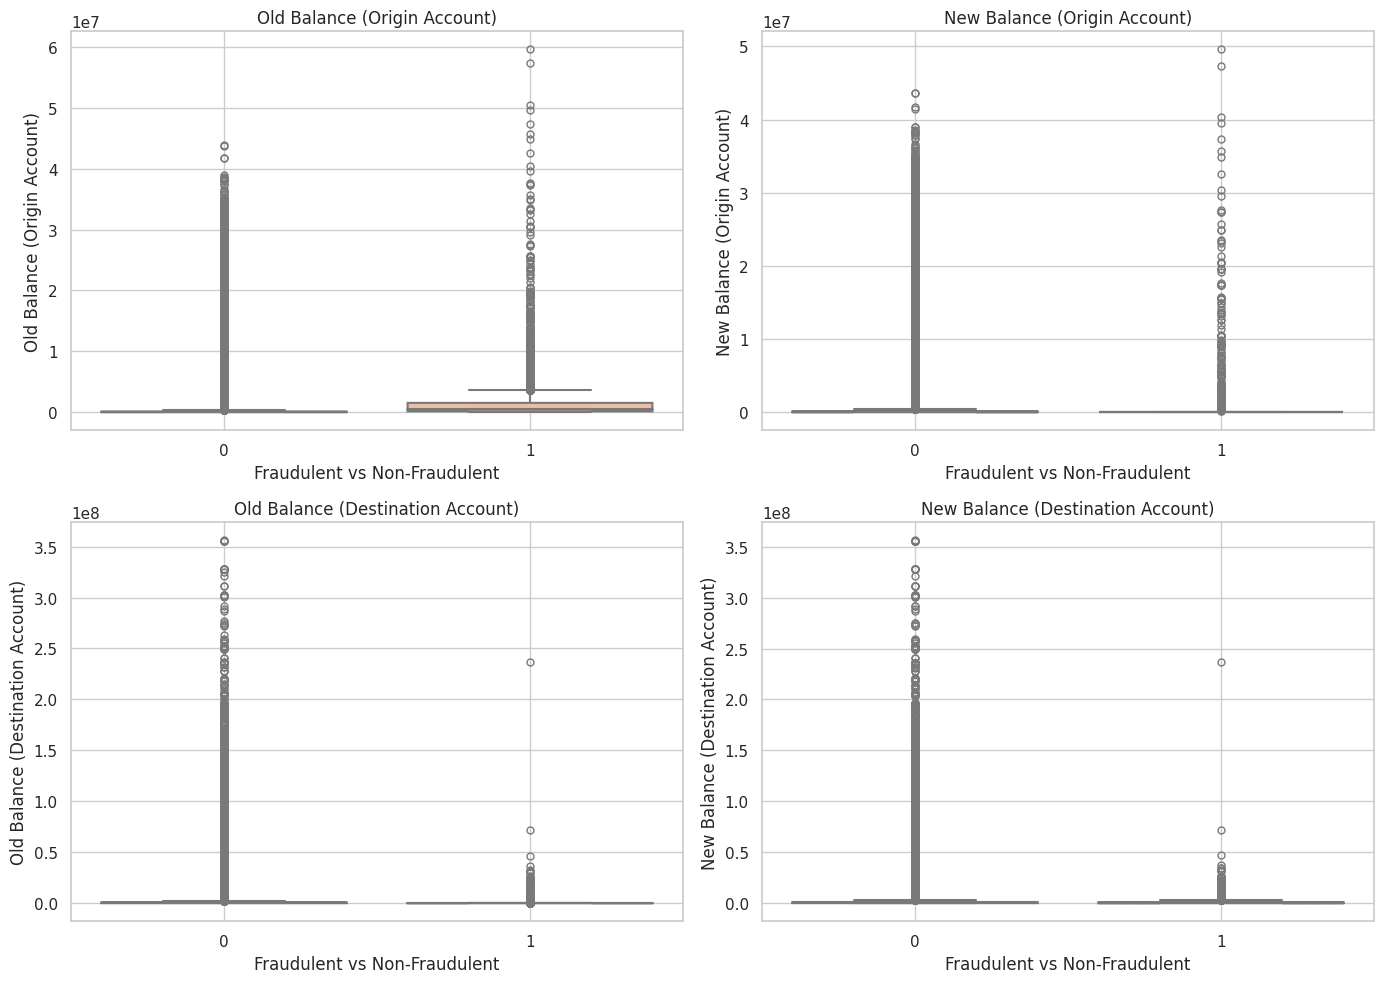

In [39]:
# Set up the figure size
plt.figure(figsize=(14, 10))

# Old balance of the origin account
plt.subplot(2, 2, 1)
sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.5)
plt.title("Old Balance (Origin Account)")
plt.xlabel("Fraudulent vs Non-Fraudulent")
plt.ylabel("Old Balance (Origin Account)")
plt.grid(True)

# New balance of the origin account
plt.subplot(2, 2, 2)
sns.boxplot(x='isFraud', y='newbalanceOrig', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.5)
plt.title("New Balance (Origin Account)")
plt.xlabel("Fraudulent vs Non-Fraudulent")
plt.ylabel("New Balance (Origin Account)")
plt.grid(True)

# Old balance of the destination account
plt.subplot(2, 2, 3)
sns.boxplot(x='isFraud', y='oldbalanceDest', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.5)
plt.title("Old Balance (Destination Account)")
plt.xlabel("Fraudulent vs Non-Fraudulent")
plt.ylabel("Old Balance (Destination Account)")
plt.grid(True)

# New balance of the destination account
plt.subplot(2, 2, 4)
sns.boxplot(x='isFraud', y='newbalanceDest', data=df, palette="coolwarm", notch=True, fliersize=5, linewidth=1.5)
plt.title("New Balance (Destination Account)")
plt.xlabel("Fraudulent vs Non-Fraudulent")
plt.ylabel("New Balance (Destination Account)")
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


Origin account balances: Fraudulent transactions typically have higher initial balances, particularly in the "old balance" of the origin account. Non-fraudulent transactions cover a wider range, including many transactions with very low starting balances.
                                  
Destination account balances: The destination account balances follow similar trends. Fraudulent transactions appear to involve accounts with larger balances.
                                               
Changes in balances: Fraudulent transactions cause more extreme changes in balances, especially in the destination account, where the "new balance" grows significantly.

🔔These findings indicate that fraudulent transactions are frequently associated with higher account balances and more significant balance changes, which can be important factors to consider during fraud detection models.

=>Fraud in this specific dataset the fraudulent behavior of the agents aims to profit by taking control on customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

In [40]:
df[df['isFraud']==1].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
count,8213.000000,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8213.0,8213.000000,8213.000000
mean,368.413856,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06,1.0,0.001948,15.869475
std,216.388690,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06,0.0,0.044097,9.021448
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,1.000000
25%,181.000000,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,8.000000
50%,367.000000,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03,1.0,0.000000,16.000000
75%,558.000000,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06,1.0,0.000000,24.000000
max,743.000000,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.0,1.000000,31.000000


# **Transactions that empties funds in one account**

In [41]:
len(df[(df['amount'] == df['oldbalanceOrg'])])

8034

In [42]:
len(df[(df['amount'] == df['oldbalanceOrg']) & (df['isFraud'] == 1)] )

8034

So all transactions that empty funds are marked as fraud.
But, there are 8213 fraud transactions in total.
=> Remaining transactions could be outliers?

In [43]:
df_outliers = df[(df['amount'] != df['oldbalanceOrg']) & (df['isFraud'] == 1)]

In [44]:
df_outliers.groupby('type')['type'].count()

,type
type,
CASH_OUT,25
TRANSFER,154


In [45]:
df_outliers[df_outliers['type'] == 'CASH_OUT'].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
count,25.000000,25.000000,25.000000,25.0000,2.500000e+01,2.500000e+01,25.0,25.0,25.00000
mean,56.880000,220121.416800,17031.663200,11950.7044,5.806669e+05,1.185674e+06,1.0,0.0,2.80000
std,78.015127,158136.453984,69138.559766,59753.5220,1.613350e+06,2.341533e+06,0.0,0.0,3.21455
min,1.000000,23292.300000,0.000000,0.0000,0.000000e+00,4.061122e+04,1.0,0.0,1.00000
25%,13.000000,95428.320000,0.000000,0.0000,0.000000e+00,2.250277e+05,1.0,0.0,1.00000
50%,19.000000,181728.110000,0.000000,0.0000,1.139700e+04,4.070058e+05,1.0,0.0,1.00000
75%,38.000000,314251.580000,0.000000,0.0000,3.989313e+05,6.784196e+05,1.0,0.0,2.00000
max,231.000000,577418.980000,340830.430000,298767.6100,7.962205e+06,9.291620e+06,1.0,0.0,10.00000


Seems like most of the fraud cashout outliers are transactions in which Original account has 0 balance before and after the transaction; and Destination account has balance in the order of  10^5
  after the transaction.

Outlier shows a pattern and thus cannot be ignored.

In [46]:
df_outliers[df_outliers['type'] == 'TRANSFER'].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
count,154.000000,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,154.0,154.000000,154.000000
mean,439.097403,9.565122e+06,1.928838e+07,1.006063e+07,2.855618e+04,5.909128e+04,1.0,0.038961,18.772727
std,213.665941,1.919552e+06,1.081729e+07,1.032873e+07,2.048429e+05,3.562933e+05,0.0,0.194133,8.888211
min,4.000000,1.231949e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,1.000000
25%,271.500000,1.000000e+07,1.227122e+07,2.455224e+06,0.000000e+00,0.000000e+00,1.0,0.000000,12.000000
50%,425.000000,1.000000e+07,1.595579e+07,6.359678e+06,0.000000e+00,0.000000e+00,1.0,0.000000,18.000000
75%,646.000000,1.000000e+07,2.370846e+07,1.493847e+07,0.000000e+00,0.000000e+00,1.0,0.000000,27.000000
max,741.000000,1.000000e+07,5.958504e+07,4.958504e+07,2.122337e+06,3.217684e+06,1.0,1.000000,31.000000


Here also, the outliers cannot be ignored because they show a pattern.

Most of the transfers attempted to transfer an amount of  
1
×
10^7
  to an empty Destination account and failed.

The atypical values ​​that we have in the 'amount' variable, can generate certain biases during our evaluation of the model, can also distort the distribution of the data, and give us less robustness in our Machine Learning algorithms. Due to all this, we decided to proceed with the imputation of these atypical values.
We will carry out the imputation with the trunction method of percentiles.

In [47]:
## Verifying percentiles from the bottom
df[['amount', 'step']].describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.5, 0.75])

,amount,step
count,6.362620e+06,6.362620e+06
mean,1.798619e+05,2.433972e+02
std,6.038582e+05,1.423320e+02
min,0.000000e+00,1.000000e+00
1%,4.494676e+02,9.000000e+00
2.5%,1.115775e+03,1.200000e+01
5%,2.224100e+03,1.600000e+01
10%,4.501300e+03,3.500000e+01
50%,7.487194e+04,2.390000e+02
75%,2.087215e+05,3.350000e+02


In [48]:
## Verifying percentiles from the top
df[['amount', 'step']].describe(percentiles=[0.5,0.75,0.9,0.95,0.975,0.98,0.99])

,amount,step
count,6.362620e+06,6.362620e+06
mean,1.798619e+05,2.433972e+02
std,6.038582e+05,1.423320e+02
min,0.000000e+00,1.000000e+00
50%,7.487194e+04,2.390000e+02
75%,2.087215e+05,3.350000e+02
90%,3.654233e+05,3.990000e+02
95%,5.186342e+05,4.900000e+02
97.5%,8.566034e+05,5.850000e+02
98%,1.019958e+06,5.940000e+02


We observe that there are many atypical values ​​in the upper part for the variable 'amount', by convention we will carry out the analysis with the I
Q
R
=
Q
3
−
Q
1
 In this way, our new higher truncation limit will be the P
75
+
1.5
∗
I
Q
R

In [49]:

# Describing the 'amount' column and calculating specific percentiles
percentiles = df['amount'].describe(percentiles=[0.25, 0.75])

# Extracting the 25th and 75th percentiles (iloc indices will give you 5th and 7th rows in the describe output)
result = percentiles.iloc[5:7].tolist()

print(result)


[74871.94, 208721.4775]


In [50]:
# Get descriptive statistics for the 'amount' column, including the 25th and 75th percentiles
amount_desc = df['amount'].describe(percentiles=[0.25, 0.75])

# Extract the 25th and 75th percentiles
p25 = amount_desc['25%']
p75 = amount_desc['75%']

# Calculate the Interquartile Range (IQR)
IQR = p75 - p25

# Calculate the Upper Threshold Score (LTS) for detecting outliers
LTS = p75 + 1.5 * IQR


In [51]:
# Get the minimum value (percentile) of the 'amount' column
pmin = df['amount'].describe()['min']

# Display the result
pmin


np.float64(0.0)

In [52]:
df['amount'] = df['amount'].clip(lower=pmin, upper=LTS)


In [53]:
df[['amount', 'step']].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.975, 0.98, 0.99])


,amount,step
count,6.362620e+06,6.362620e+06
mean,1.322667e+05,2.433972e+02
std,1.462368e+05,1.423320e+02
min,0.000000e+00,1.000000e+00
50%,7.487194e+04,2.390000e+02
75%,2.087215e+05,3.350000e+02
90%,3.654233e+05,3.990000e+02
95%,5.017193e+05,4.900000e+02
97.5%,5.017193e+05,5.850000e+02
98%,5.017193e+05,5.940000e+02


<ipython-input-54-e79633c9911e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


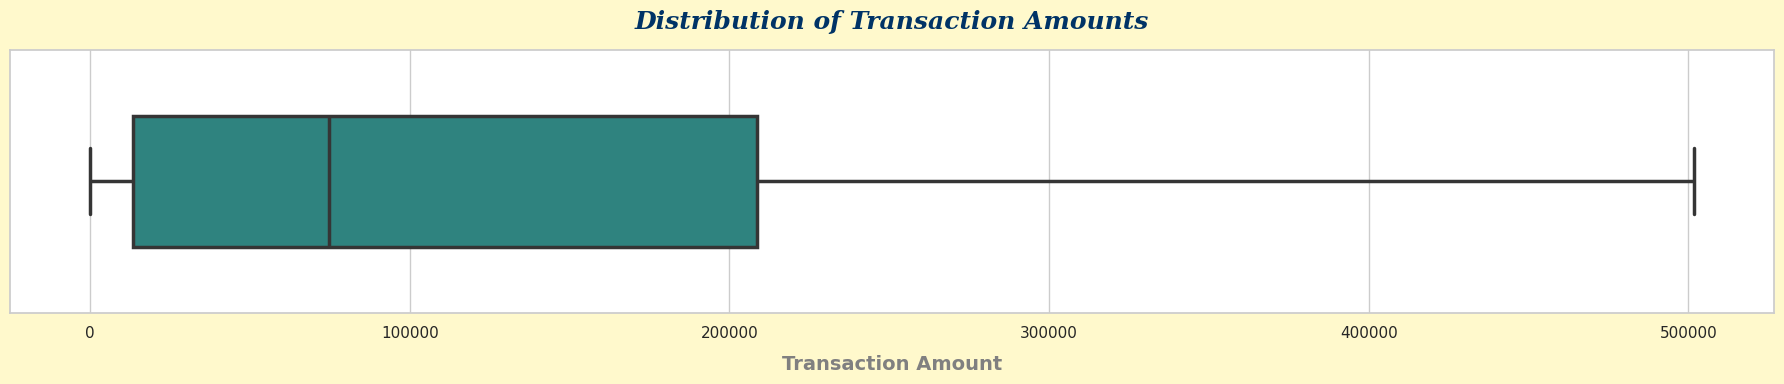

In [54]:
# Set up the figure size and style
plt.figure(figsize=(18, 4))
sns.set(style='whitegrid')

# Create the boxplot for 'amount' variable
sns.boxplot(
    x=df['amount'],  # Use the 'amount' column directly
    orient='h',
    palette='viridis',  # Sophisticated color palette
    width=0.5,  # Adjust box width
    fliersize=5,  # Size of outliers
    linewidth=2.5  # Thickness of box lines
)

# Customize background color
plt.gcf().set_facecolor('#fff9cc')  # Soft yellow-beige

# Customize title with advanced font styling
plt.title(
    'Distribution of Transaction Amounts',
    pad=15,
    fontsize=18,
    fontweight='bold',
    fontstyle='italic',
    color='#003366',  # Dark blue for title
    fontname='DejaVu Serif'
)

# Remove x-axis label clutter for elegance
plt.xlabel('Transaction Amount', fontsize=14, weight='bold', labelpad=10, color='gray')

# Tidy y-axis
plt.yticks([])  # Remove y-axis labels for better clarity

# Extra margin for clarity
plt.tight_layout()

# Display the plot
plt.show()

We validate in our new Boxploot chart, which we no longer have the presence of atypicals that we had initially. In this way we can manipulate the data better, avoiding some bias and making our models more robust.

# **Feature engineering**

# **Creation of part of the day**

**Creating part of the day**

In [55]:
def part_of_the_day(hour):
    hour_of_day = hour % 24
    if 6 <= hour_of_day < 12:
        return 'morning'
    elif 12 <= hour_of_day < 18:
        return 'afternoon'
    elif 18 <= hour_of_day < 24:
        return 'evening'
    else:
        return 'night'

# Apply to create a new column
df['part_of_the_day'] = df['step'].apply(part_of_the_day)




# **Creation of Transaction pair code**

Now we create a new variable, called "Transaction pair code", joining the first letters of the two columns, "Nameorig" and "Namedest", which represent the client that starts the operation and the client that received the transaction

In [56]:
df['Transaction pair code'] = df['nameOrig'].apply(lambda x: re.search('[A-Za-z]', x).group()) + \
               df['nameDest'].apply(lambda x: re.search('[A-Za-z]', x).group())

# Focus only on transfer and cashout

From the exploratory data analysis (EDA) , we explored  that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.

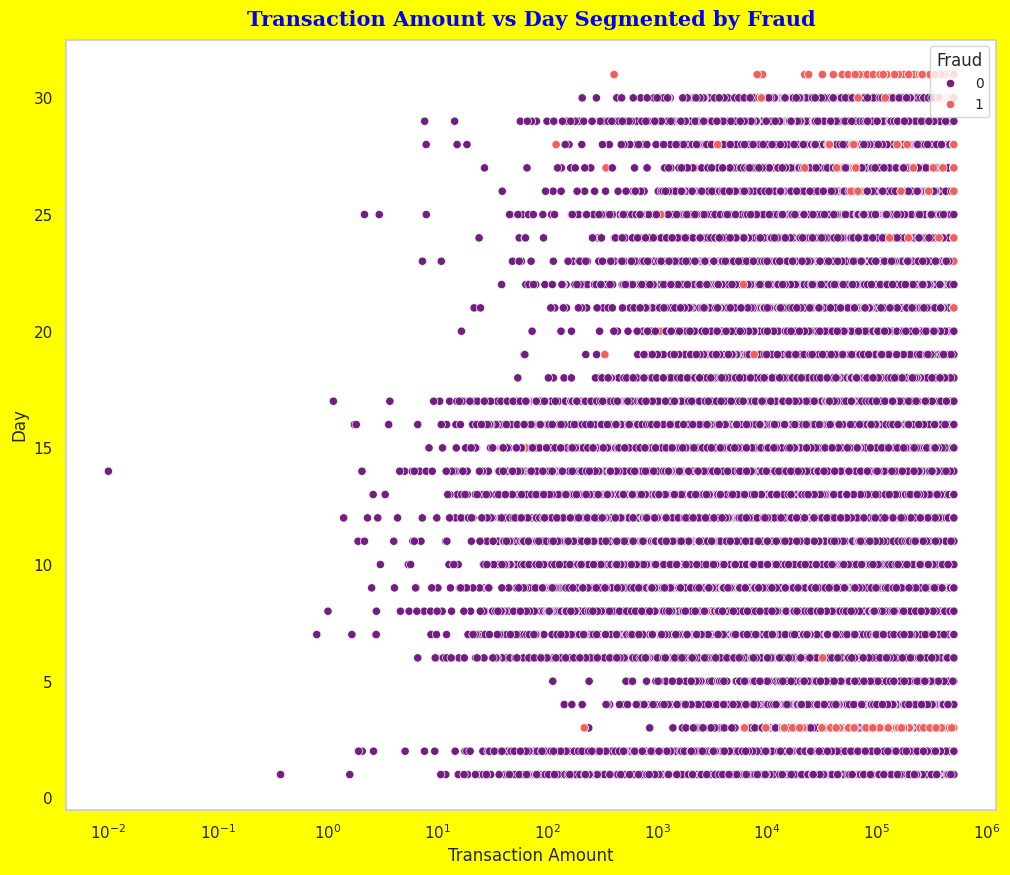

In [57]:
# Filter for only TRANSFER and CASH_OUT transactions
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Create the scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(x='amount', y='day', hue='isFraud', data=df_filtered, palette='magma')

# Labels and title
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Day', fontsize=12)
plt.title('Transaction Amount vs Day Segmented by Fraud',
          fontsize=15, pad=10,
          fontdict={'fontsize': 15, 'fontfamily': 'serif',
                    'fontstyle': 'normal', 'fontweight': 'bold', 'color': 'blue'})

# Legend
plt.legend(title='Fraud', fontsize=10, loc='upper right')

# Styling
plt.gcf().set_facecolor('yellow')
plt.grid(False)

plt.xscale('log')

plt.show()



We observed that the fraud was performed duriing the first days and the last days of the month, this could be understood because many people receive their salaries for those days.

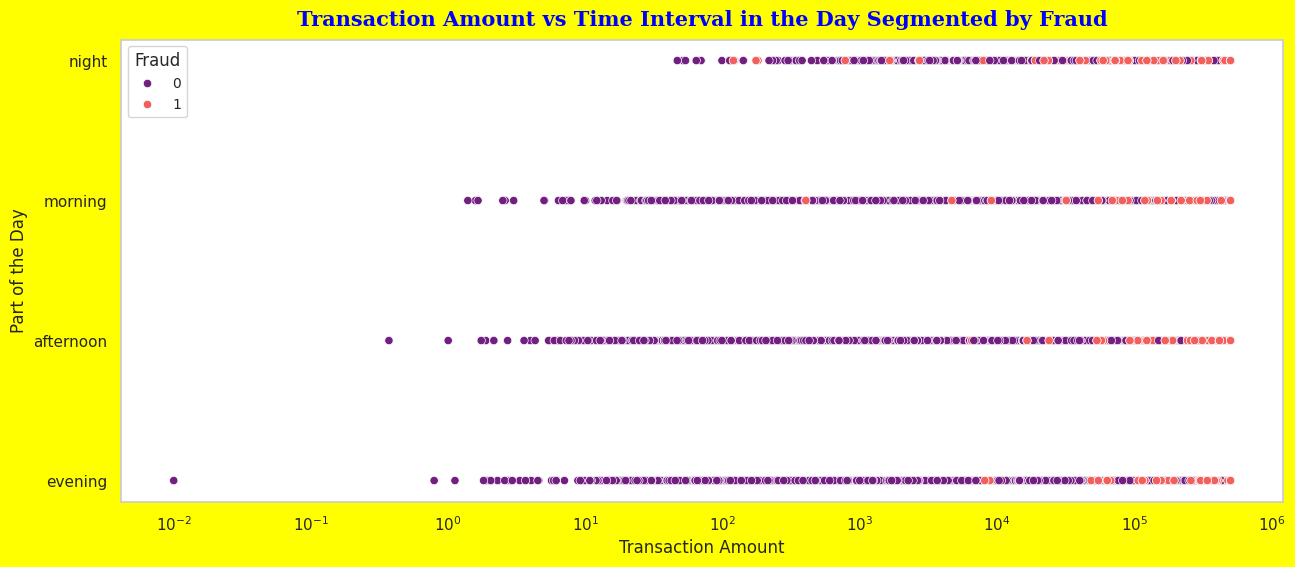

In [58]:
# Filter only TRANSFER and CASH_OUT transactions
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Create scatter plot
plt.figure(figsize=(15, 6))
sns.scatterplot(x='amount', y='part_of_the_day', hue='isFraud', data=df_filtered, palette='magma')

# Labels and title
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Part of the Day', fontsize=12)
plt.title('Transaction Amount vs Time Interval in the Day Segmented by Fraud',
          pad=10,
          fontdict={'fontsize': 15, 'fontfamily': 'serif',
                    'fontstyle': 'normal', 'fontweight': 'bold', 'color': 'blue'})

# Legend and styling
plt.legend(title='Fraud', fontsize=10, loc='best')
plt.gcf().set_facecolor('yellow')
plt.grid(False)

# Optional: Set x-axis to logarithmic scale (for better transaction amount display)
plt.xscale('log')

# Show plot
plt.show()


We observe that fraudulent transactions have occurred at all intervals of the day.
It is displayed, slight predominance of fraud at night and morning.

<ipython-input-59-43f07c741ed4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='part_of_the_day', y='count', data=transaction_counts, palette='viridis')


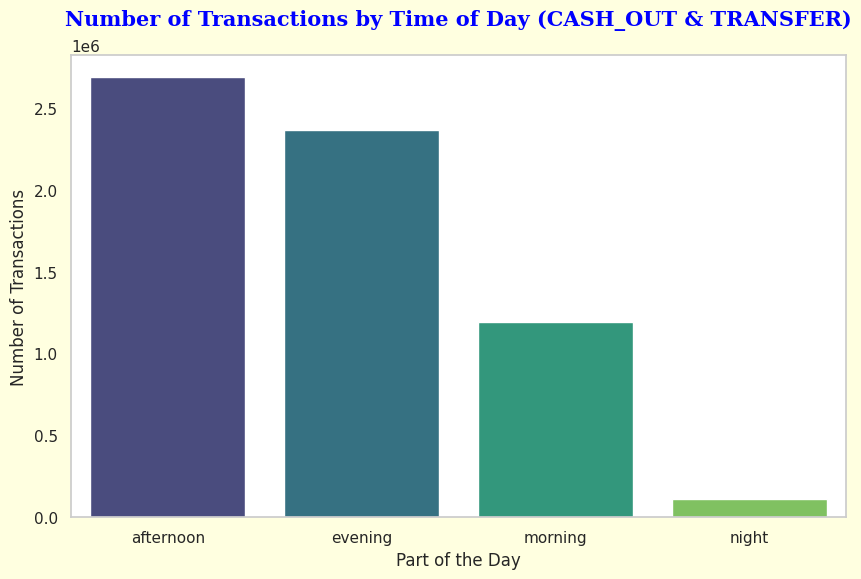

In [59]:
filtered_df = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]
# Count transactions for each part of the day
transaction_counts =df['part_of_the_day'].value_counts().reset_index()
transaction_counts.columns = ['part_of_the_day', 'count']

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='part_of_the_day', y='count', data=transaction_counts, palette='viridis')

# Labels and title
plt.xlabel('Part of the Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Time of Day (CASH_OUT & TRANSFER)', pad=10,
          fontdict={'fontsize': 15, 'fontfamily': 'serif', 'fontweight': 'bold', 'color': 'blue'})

# Optional: remove grid and set background
plt.grid(False)
plt.gcf().set_facecolor('lightyellow')

# Show plot
plt.show()

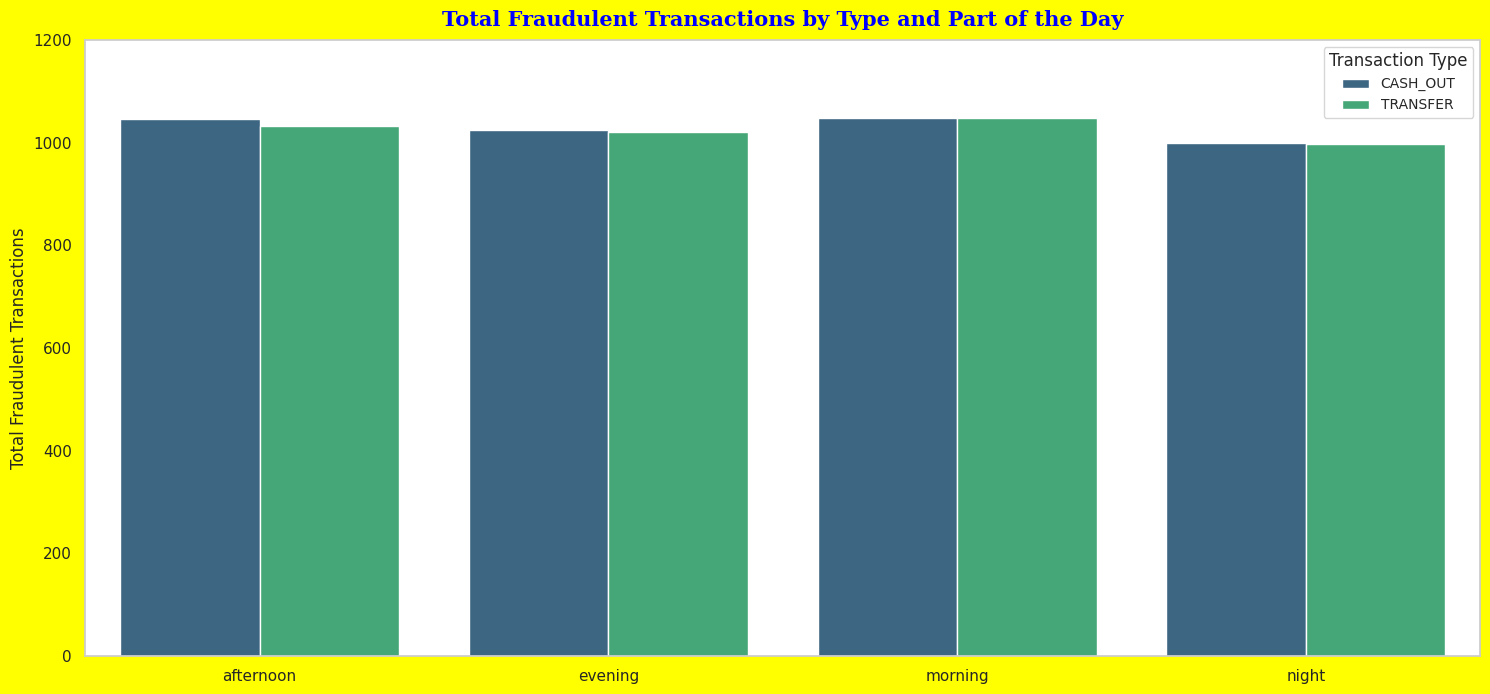

In [60]:
# Group by type and part of the day and count the number of occurrences
df_amount_fraud = df[df['isFraud'] == 1][['amount', 'part_of_the_day', 'type', 'day']] \
    .sort_values(by='amount', ascending=False) # Define df_amount_fraud before use
df_groupby_type_fraude_count = df_amount_fraud.groupby(['type', 'part_of_the_day']).size().reset_index(name='count')

# Create a grouped bar chart for the number of fraudulent transactions by type and part of the day
plt.figure(figsize=(18, 8))
sns.barplot(data=df_groupby_type_fraude_count, x='part_of_the_day', y='count', hue='type', palette='viridis', dodge=True)

# Set labels and title of the chart
plt.xlabel('', fontsize=12)
plt.ylabel('Total Fraudulent Transactions', fontsize=12)
plt.title('Total Fraudulent Transactions by Type and Part of the Day', fontsize=15, pad=10, fontdict={'fontsize': 15, 'fontfamily':'serif',
                                                                                                    'fontstyle':'normal', 'fontweight': 'heavy', 'color': 'blue'})

# Set y-axis limits
plt.ylim(0, 1200)

# Add legend
plt.legend(title='Transaction Type', fontsize=10)

# Set the background color of the chart
plt.gcf().set_facecolor('yellow')

# Remove gridlines
plt.grid(False)

# Show the plot
plt.show()



In [61]:
# Grouping by 'type' and 'part_of_the_day' and counting the occurrences, then dropping unnecessary columns
df_groupby_type_fraud_count = df_amount_fraud.groupby(['type', 'part_of_the_day']).count().drop(columns=['day'])

# Display the result
df_groupby_type_fraud_count


amount
type     part_of_the_day        
CASH_OUT afternoon          1045
         evening            1025
         morning            1047
         night               999
TRANSFER afternoon          1032
         evening            1021
         morning            1047
         night               997

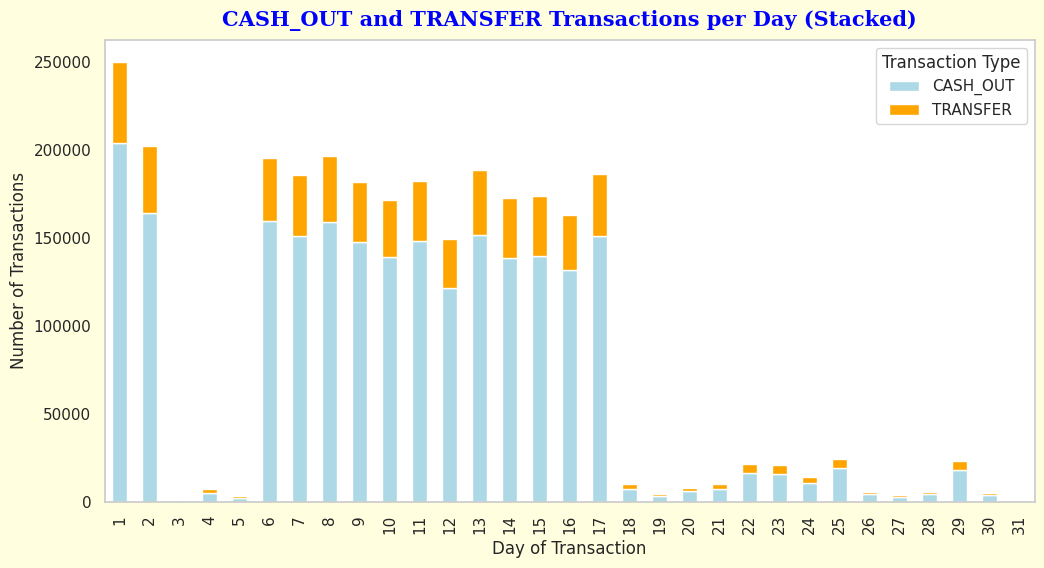

In [62]:
# Filter for only CASH_OUT and TRANSFER transactions
filtered_df = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]

# Group by day and type to get counts
day_type_counts = filtered_df.groupby(['day', 'type']).size().unstack(fill_value=0)

# Plot: Stacked bar chart for both types
ax = day_type_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['lightblue', 'orange'])

# Labels and title
plt.xlabel('Day of Transaction')
plt.ylabel('Number of Transactions')
plt.title('CASH_OUT and TRANSFER Transactions per Day (Stacked)', pad=10,
          fontdict={'fontsize': 15, 'fontfamily': 'serif',
                    'fontstyle': 'normal', 'fontweight': 'bold', 'color': 'blue'})

# Clean visuals
plt.grid(False)
plt.gcf().set_facecolor('lightyellow')
plt.legend(title='Transaction Type')

# Show plot
plt.show()



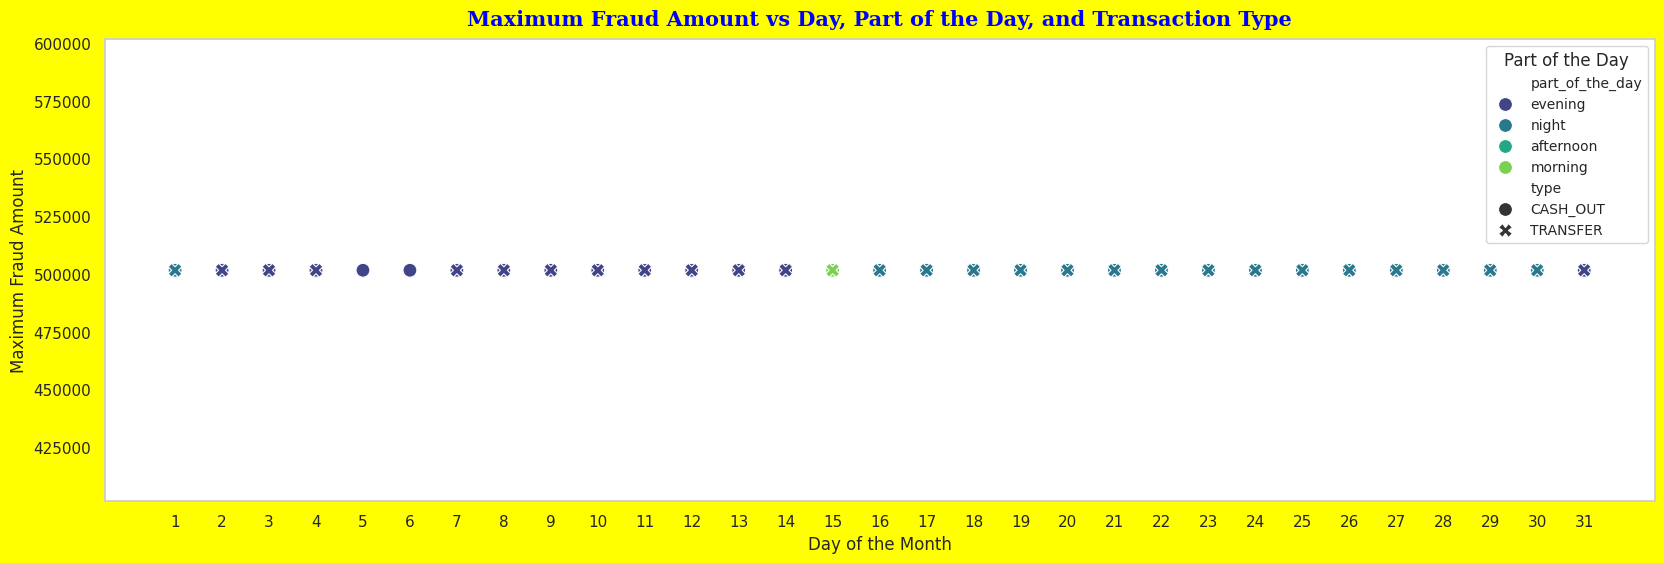

In [63]:
# Set figure size
plt.figure(figsize=(20, 6))

# Create scatter plot for maximum fraud amount by day, part of the day, and transaction type
sns.scatterplot(data=df_amount_fraud[df_amount_fraud['amount'] == df_amount_fraud['amount'].max()],
                x='day', y='amount',
                hue='part_of_the_day', style='type', s=100, palette='viridis')

# Adjust y-axis limits to show the maximum fraud amount with some padding
plt.ylim(df_amount_fraud['amount'].max()-100000, df_amount_fraud['amount'].max()+100000)

# Add labels and title
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Maximum Fraud Amount', fontsize=12)
plt.title('Maximum Fraud Amount vs Day, Part of the Day, and Transaction Type', fontsize=15, pad=10,
          fontdict={'fontsize': 15, 'fontfamily': 'serif', 'fontweight': 'heavy', 'color': 'blue'})

# Display the legend at the top right
plt.legend(title='Part of the Day', loc='upper right', fontsize=10)

# Set the background color
plt.gcf().set_facecolor('yellow')

# Remove the grid lines
plt.grid(False)

# Set x-axis ticks for days 1 to 31
plt.xticks(range(1, 32))

# Show the plot
plt.show()


In [64]:
df_amount_fraud[df_amount_fraud['amount'] == df_amount_fraud['amount'].max()]


,amount,part_of_the_day,type,day
6362619,501719.33875,evening,CASH_OUT,31
6362618,501719.33875,evening,TRANSFER,31
6362617,501719.33875,evening,CASH_OUT,31
6362601,501719.33875,evening,CASH_OUT,31
6362600,501719.33875,evening,TRANSFER,31
...,...,...,...,...
3162,501719.33875,night,TRANSFER,1
3060,501719.33875,night,CASH_OUT,1
3059,501719.33875,night,TRANSFER,1
970,501719.33875,night,CASH_OUT,1


We observe that the largest amount of fraudulent transactions is around 500000 in cash_out and transfer.

In [65]:
# Grouping by 'type' and 'part_of_the_day', and summing numerical columns
df_groupby_type_fraud = df_amount_fraud.groupby(['type', 'part_of_the_day']).sum().drop(columns=['day'])

# Optionally, reset the index to turn 'type' and 'part_of_the_day' into regular columns
df_groupby_type_fraud = df_groupby_type_fraud.reset_index()

# Display the result
df_groupby_type_fraud


,type,part_of_the_day,amount
0,CASH_OUT,afternoon,3.358913e+08
1,CASH_OUT,evening,3.372573e+08
2,CASH_OUT,morning,3.341002e+08
3,CASH_OUT,night,3.369194e+08
4,TRANSFER,afternoon,3.350027e+08
5,TRANSFER,evening,3.390871e+08
6,TRANSFER,morning,3.373941e+08
7,TRANSFER,night,3.373740e+08


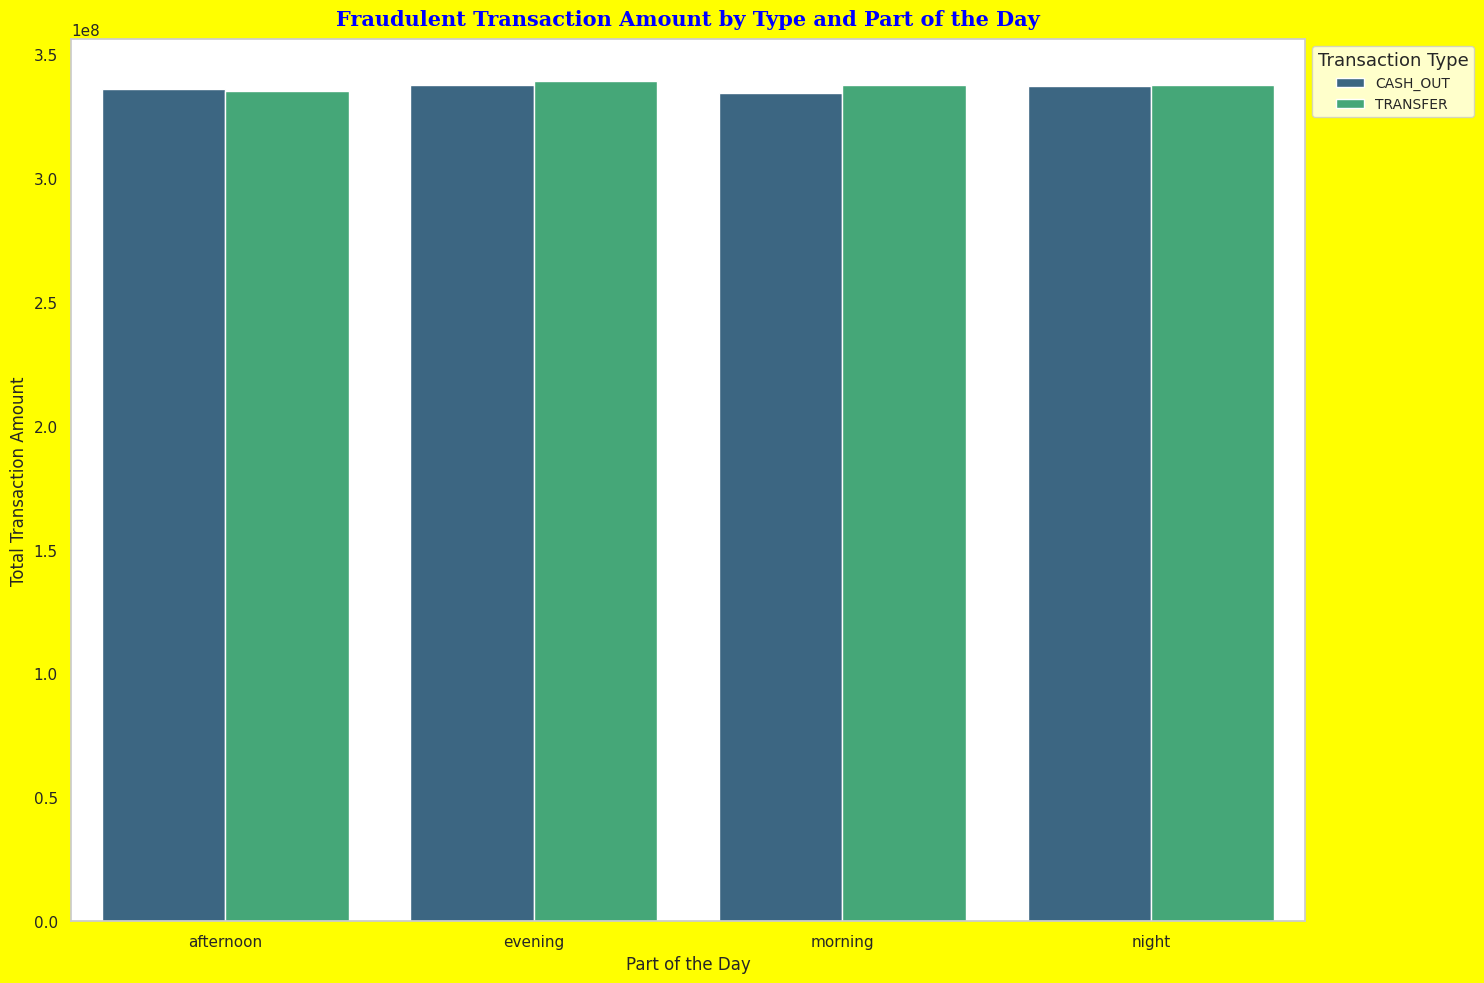

In [66]:

# Group by type and part of the day and count the number of occurrences
df_amount_fraud = df[df['isFraud'] == 1][['amount', 'part_of_the_day', 'type', 'day']] \
    .sort_values(by='amount', ascending=False) # Define df_amount_fraud before use
df_groupby_type_fraud_count = df_amount_fraud.groupby(['type', 'part_of_the_day']).size().reset_index(name='count')
# Create a grouped bar chart for transaction amounts by type and part of the day
plt.figure(figsize=(15, 10))
sns.barplot(data=df_groupby_type_fraud, x='part_of_the_day', y='amount', hue='type', palette='viridis', dodge=True)

# Set labels and title
plt.xlabel('Part of the Day', fontsize=12)
plt.ylabel('Total Transaction Amount', fontsize=12)
plt.title('Fraudulent Transaction Amount by Type and Part of the Day', fontsize=15, pad=10, fontdict={'fontsize': 15, 'fontfamily':'serif',
                                                                                                     'fontstyle':'normal', 'fontweight': 'heavy', 'color': 'blue'})

# Adjust legend and style
plt.legend(title='Transaction Type', fontsize=10, title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1))

# Set the background color of the plot
plt.gcf().set_facecolor('yellow')

# Disable gridlines for a cleaner look
plt.grid(False)

# Show the plot
plt.tight_layout()  # Ensure everything fits within the plot area
plt.show()


# Preprocessing

In [67]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,part_of_the_day,Transaction pair code
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,night,CM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,night,CM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,night,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,night,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,night,CM


In [68]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('Total {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nTotal {} categorical features : {}'.format(len(categorical_features), categorical_features))


Total 9 numerical features : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'day']

Total 5 categorical features : ['type', 'nameOrig', 'nameDest', 'part_of_the_day', 'Transaction pair code']


In [69]:
correlation = df[['step','amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',  'isFraud', 'isFlaggedFraud', 'day']].corr()

<Axes: >

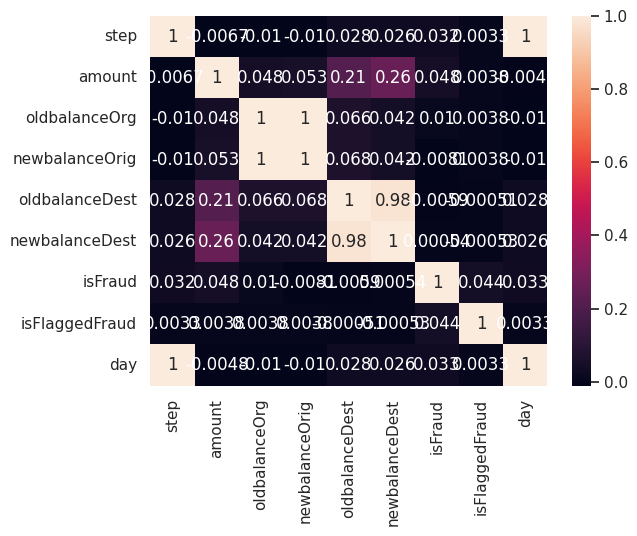

In [70]:
sns.heatmap(data=correlation, annot=True)

▶ we can clearly see that oldbalanceDest and newbalanceDest are highly correlated (0.98), suggesting they capture similar information.

▶ amount has moderate correlation with newbalanceDest (0.26), demonstrating that higher transaction amounts tend to correlate with higher destination balances.

▶ No significant correlation between isFraud and other variables, which suggests fraud detection is not easily linked to balance amounts alone.

# Remove the unecessary columns

As the customer id is not needed to make predictions from the dataset, let's drop columns nameOrig and nameDest.
Also the isFlaggedFraud and all balances and step


In [71]:
df = df.drop(['nameOrig', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'step' ], axis = 1)

In [72]:
df.head()

,type,amount,isFraud,day,part_of_the_day,Transaction pair code
0,PAYMENT,9839.64,0,1,night,CM
1,PAYMENT,1864.28,0,1,night,CM
2,TRANSFER,181.00,1,1,night,CC
3,CASH_OUT,181.00,1,1,night,CC
4,PAYMENT,11668.14,0,1,night,CM


In [73]:
print("Columns after drop:", df.columns)

Columns after drop: Index(['type', 'amount', 'isFraud', 'day', 'part_of_the_day',
       'Transaction pair code'],
      dtype='object')


# Categorical vars encoding

In [74]:
# Create dummy variables for 'type', 'type_2', and 'part_of_the_day'
df = pd.get_dummies(df, columns=['type', 'Transaction pair code', 'part_of_the_day'], drop_first=False)


In [75]:
print(df.head())



     amount  isFraud  day  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0   9839.64        0    1         False          False       False   
1   1864.28        0    1         False          False       False   
2    181.00        1    1         False          False       False   
3    181.00        1    1         False           True       False   
4  11668.14        0    1         False          False       False   

   type_PAYMENT  type_TRANSFER  Transaction pair code_CC  \
0          True          False                     False   
1          True          False                     False   
2         False           True                      True   
3         False          False                      True   
4          True          False                     False   

   Transaction pair code_CM  part_of_the_day_afternoon  \
0                      True                      False   
1                      True                      False   
2                     False                 

In [76]:
print("Columns after encoding:", df.columns)


Columns after encoding: Index(['amount', 'isFraud', 'day', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'Transaction pair code_CC', 'Transaction pair code_CM',
       'part_of_the_day_afternoon', 'part_of_the_day_evening',
       'part_of_the_day_morning', 'part_of_the_day_night'],
      dtype='object')


# Data balancing

In [77]:
pip install imbalanced-learn

In [78]:
# Count the number of fraudulent and non-fraudulent transactions
fraud_count = df['isFraud'].value_counts()
print(fraud_count)

# Check the ratio of fraud to non-fraud
imbalance_ratio = fraud_count[0] / fraud_count[1]  # Majority / Minority
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

isFraud
0    6354407
1       8213
Name: count, dtype: int64
Imbalance Ratio: 773.70


In [79]:
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

In [80]:
df_majority = df[df['isFraud'] == 0]
df_minority = df[df['isFraud'] == 1]


In [81]:
# Undersample the majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,      # sample without replacement
                                    n_samples=300000,   # reduce to 300,000
                                    random_state=42)

In [82]:
# Combine the undersampled majority class with the minority class
df_combined = pd.concat([df_majority_undersampled, df_minority], axis=0).reset_index(drop=True)

In [83]:
# Separate features and target variable
X_combined = df_combined.drop(columns='isFraud')  # All columns except 'isFraud'
y_combined = df_combined['isFraud']               # Only the 'isFraud' column

In [84]:
# Oversample the minority class using RandomOverSampler
ros = RandomOverSampler(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_combined, y_combined)


In [85]:
# Combine the resampled data into a single DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Check class balance
print(df_resampled['isFraud'].value_counts())


isFraud
0    300000
1    300000
Name: count, dtype: int64


In [86]:
df_resampled

,amount,day,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Transaction pair code_CC,Transaction pair code_CM,part_of_the_day_afternoon,part_of_the_day_evening,part_of_the_day_morning,part_of_the_day_night,isFraud
0,183806.32000,7,False,True,False,False,False,True,False,False,True,False,False,0
1,521.37000,6,False,False,False,True,False,False,True,True,False,False,False,0
2,3478.18000,8,False,False,False,True,False,False,True,False,False,True,False,0
3,1716.05000,15,False,False,False,True,False,False,True,False,True,False,False,0
4,253129.93000,15,True,False,False,False,False,True,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,501719.33875,7,False,False,False,False,True,True,False,False,False,False,True,1
599996,67128.33000,26,False,False,False,False,True,True,False,False,True,False,False,1
599997,346795.44000,24,False,True,False,False,False,True,False,False,False,False,True,1
599998,237776.02000,18,False,True,False,False,False,True,False,False,False,True,False,1


<ipython-input-87-384aca7eba25>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


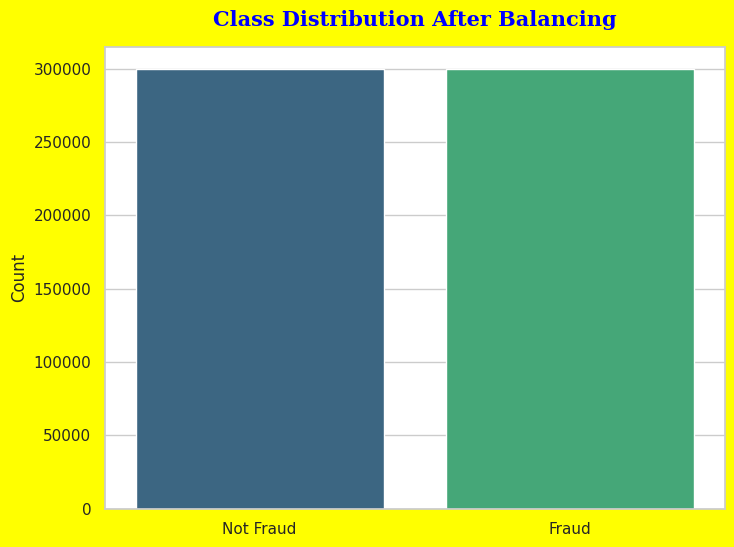

In [87]:
# Create bar chart after class balancing
plt.figure(figsize=(8, 6))
sns.barplot(
    x=df_resampled['isFraud'].value_counts().index,
    y=df_resampled['isFraud'].value_counts().values,
    palette='viridis'
)

# Set labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('')
plt.title('Class Distribution After Balancing', pad=15, fontdict={
    'fontsize': 15, 'fontfamily': 'serif',
    'fontstyle': 'normal', 'fontweight': 'heavy',
    'color': 'blue'
})
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

# Set background color
plt.gcf().set_facecolor('yellow')
plt.show()


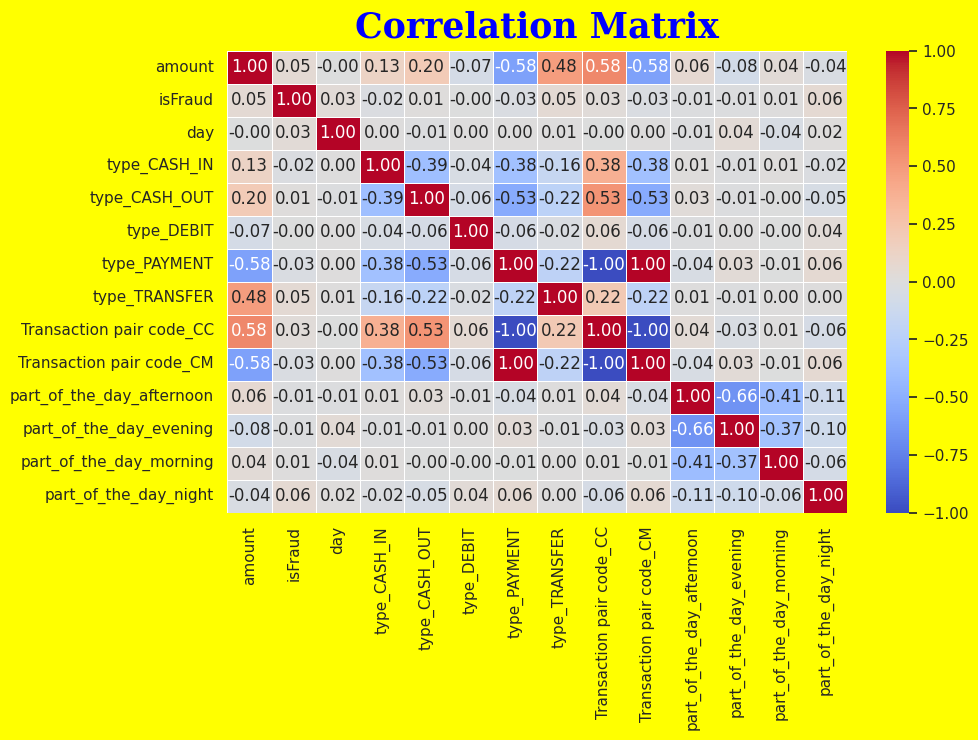

In [88]:
# Correlation matrix after balancing the target variable
# Apply one-hot encoding to categorical variables



correlation_matrix = df.corr()

# Create heatmap for correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    vmin=-1, vmax=1,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)

# Set title and style
plt.title('Correlation Matrix', pad=10, fontdict={
    'fontsize': 25, 'fontfamily': 'serif',
    'fontstyle': 'normal', 'fontweight': 'heavy',
    'color': 'blue'
})

# Set background color
plt.gcf().set_facecolor('yellow')
plt.show()


▶ Our target variable 'isFraud' shows low correlation with other features, which isn't ideal. However, data analysis revealed that 'transfer' and 'cashout' transactions are most critical, as fraud primarily occurs within these types.

▶On the contrary, although the Cash_in and Payment variables have a relatively considerable correlation with other important variables such as CC and CM, we decided to maintain them, because these variables have enough transactions but with very low amounts, so, this can affect the analysis if we eliminate it.

▶ Finally,
The debit variable has no high correlation with other variables, but it also does not have a correlation with the objective variable, so it is not so relevant, and there does not register many transactions, we decided to eliminate it.

▶In this case, morning, afternoon, and evening are correlated, and our analysis shows that fraud occurs across all these time intervals. Therefore, it's important to retain these variables.

▶Although the night variable shows low correlation with the Objective variable, fraud is still present during this time, so we will also keep it.

▶The day variable, although it does not correlate with the target variable, we consider an important variable for fraud analysis, since in different days the cases are presented.

▶On the other hand we see that the CC, CM, Payment, cash_out, cash_in and amount variables are correlated, highly, we consider that these variables are important for the analysis, since they give us a lot of reference when analyzing whether a transaction is or not fraudulent.

# **ML Models Construction**

In [89]:
# Define target variable and features
y = df_resampled['isFraud']
x = df_resampled.drop(columns='isFraud')

# Split the data into training and testing sets (80% train, 20% test) with stratification
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=77, stratify=y)

In [90]:
# Define target variable and features
y = df_resampled['isFraud']
x = df_resampled.drop(columns='isFraud')

# Split the data into temporary and test sets (90% temp, 10% test) with stratification
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.10, random_state=77, stratify=y)

# Split the temporary set into training and validation sets (80% train, 10% validation) with stratification
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=1/9, random_state=77, stratify=y_temp)


In [91]:
x_train.head()

,amount,day,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Transaction pair code_CC,Transaction pair code_CM,part_of_the_day_afternoon,part_of_the_day_evening,part_of_the_day_morning,part_of_the_day_night
469192,307455.42000,28,False,False,False,False,True,True,False,False,True,False,False
214248,100349.21000,16,False,True,False,False,False,True,False,False,True,False,False
371258,501719.33875,31,False,False,False,False,True,True,False,False,False,True,False
2277,501719.33875,8,False,False,False,False,True,True,False,True,False,False,False
528439,501719.33875,5,False,True,False,False,False,True,False,False,False,False,True


In [92]:
y_train.head()

,isFraud
469192,1
214248,0
371258,1
2277,0
528439,1


In [93]:
x_train.shape, y_train.shape

((480000, 13), (480000,))

In [94]:
x_test.shape, y_test.shape

((60000, 13), (60000,))

In [95]:
x_val.shape, y_val.shape

((60000, 13), (60000,))

In [98]:
#for RF
#Drop columns before scaling
x_train_rf = x_train.drop(columns=['type_DEBIT', 'part_of_the_day_morning', 'part_of_the_day_evening','part_of_the_day_afternoon'])
x_test_rf = x_test.drop(columns=['type_DEBIT', 'part_of_the_day_morning', 'part_of_the_day_evening', 'part_of_the_day_afternoon'])


# Then scale the data without them
scaler_rf = StandardScaler()
x_train_scaled_rf = scaler_rf.fit_transform(x_train)
x_test_scaled_rf = scaler_rf.transform(x_test)



In [99]:
joblib.dump(scaler_rf, 'scaler_rf.pkl')

['scaler_rf.pkl']

**Standardizing training data**

In [100]:
standarscaler = StandardScaler()
standarscaler.fit(x_train)

StandardScaler()

In [101]:
x_train_scaled = standarscaler.transform(x_train)
x_test_scaled = standarscaler.transform(x_test)

In [102]:
joblib.dump(standarscaler, 'scaler.pkl')

['scaler.pkl']

# **PCA**

In [103]:
from sklearn.decomposition import PCA

# Keep enough components to retain 95% of the variance
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)



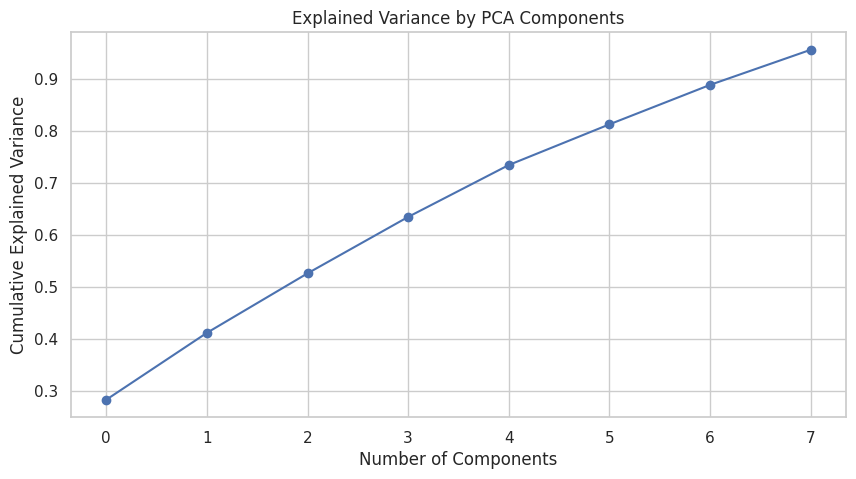

In [104]:

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()


In [105]:
joblib.dump(pca, "pca_model.pkl")

['pca_model.pkl']

# **Random Forest**

***Manual Loop***

In [106]:
n_estimators = [100, 200, 300]
max_depth = [None, 10, 20, 30]

for n in n_estimators:
    for m in max_depth:
        rf = RandomForestClassifier(max_depth=m, n_estimators = n).fit(x_train_scaled_rf,y_train)
        yhat = rf.predict(x_test_scaled_rf)
        yhat_proba = rf.predict_proba(x_test_scaled_rf)[:,1]
        print("max_depth="+str(m)+", n_estimators="+str(n)
            +"->Accuracy: "+str(accuracy_score(y_test,yhat))
            +"->Precision: "+str(precision_score(y_test,yhat))
            +"->Recall: "+str(recall_score(y_test,yhat))
            +"->F1-score: "+str(f1_score(y_test,yhat))
            +"->AUC : "+str(roc_auc_score(y_test,yhat_proba)))

max_depth=None, n_estimators=100->Accuracy: 0.9713666666666667->Precision: 0.9500063645621182->Recall: 0.9951->F1-score: 0.9720304766866371->AUC : 0.9949104322222223
max_depth=10, n_estimators=100->Accuracy: 0.8998333333333334->Precision: 0.8923268136324982->Recall: 0.9094->F1-score: 0.9007825139498795->AUC : 0.9649821861111112
max_depth=20, n_estimators=100->Accuracy: 0.9532833333333334->Precision: 0.9442937890025158->Recall: 0.9634->F1-score: 0.9537512168561387->AUC : 0.9912161544444446
max_depth=30, n_estimators=100->Accuracy: 0.9713833333333334->Precision: 0.9500365973968112->Recall: 0.9951->F1-score: 0.9720463018738909->AUC : 0.9950761972222221
max_depth=None, n_estimators=200->Accuracy: 0.9714->Precision: 0.9500668321558144->Recall: 0.9951->F1-score: 0.9720621275764384->AUC : 0.9951791088888889
max_depth=10, n_estimators=200->Accuracy: 0.9001333333333333->Precision: 0.8921850496602195->Recall: 0.9102666666666667->F1-score: 0.9011351636747624->AUC : 0.9649803438888889
max_depth=20

In [107]:
#train the model
model_rf = RandomForestClassifier(max_depth=30, n_estimators=200,random_state=42)
model_rf.fit(x_train_scaled_rf, y_train)

RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

In [108]:
y_pred_rf = model_rf.predict(x_test_scaled_rf)

In [109]:
report_rf = classification_report(y_test, y_pred_rf, target_names=["No Fraud", "Fraud"], output_dict=True)
pd.DataFrame(report_rf).style.background_gradient()

,No Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.994856,0.950067,0.971400,0.972462,0.972462
recall,0.947700,0.995100,0.971400,0.971400,0.971400
f1-score,0.970706,0.972062,0.971400,0.971384,0.971384
support,30000.000000,30000.000000,0.971400,60000.000000,60000.000000


In [110]:
## We calculate the probability prediction for our test data, this will help us for AUC-ROC calculations
# y_proba_test_rf = best_rf.predict_proba(x_test_scaled)[:,1]
y_proba_test_rf = model_rf.predict_proba(x_test_scaled_rf)[:,1]

In [111]:
from sklearn.metrics import roc_curve

# Compute FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test_rf)

# Compute Youden's J statistic
youden_j = tpr - fpr
best_index = youden_j.argmax()
best_threshold = thresholds[best_index]

print(f"Best Threshold (Youden's J): {best_threshold:.4f}")
print(f"TPR at Best Threshold: {tpr[best_index]:.4f}")
print(f"FPR at Best Threshold: {fpr[best_index]:.4f}")


Best Threshold (Youden's J): 0.4804
TPR at Best Threshold: 0.9972
FPR at Best Threshold: 0.0543


In [112]:
# Custom thresholding
custom_threshold = 0.4804  # we can later tune this based on metrics or curves

# Convert probabilities to class labels using the custom threshold
y_pred_thresh_rf = (y_proba_test_rf >= custom_threshold).astype(int)

# Recalculate metrics using the thresholded predictions
accuracy_thresh = accuracy_score(y_test, y_pred_thresh_rf)
precision_thresh = precision_score(y_test, y_pred_thresh_rf)
recall_thresh = recall_score(y_test, y_pred_thresh_rf)
f1_thresh = f1_score(y_test, y_pred_thresh_rf)
roc_auc_thresh = roc_auc_score(y_test, y_proba_test_rf)  # same proba, AUC doesn't change

# Print results
print("\n--- Metrics with Custom Threshold ---")
print(f"Threshold: {custom_threshold}")
print(f"Accuracy: {accuracy_thresh:.4f}")
print(f"Precision: {precision_thresh:.4f}")
print(f"Recall: {recall_thresh:.4f}")
print(f"F1-score: {f1_thresh:.4f}")
print(f"AUC: {roc_auc_thresh:.4f}")



--- Metrics with Custom Threshold ---
Threshold: 0.4804
Accuracy: 0.9715
Precision: 0.9484
Recall: 0.9972
F1-score: 0.9722
AUC: 0.9952


In [113]:
## In this case, we know that class 0 - No fraud and class 1 - fraud
## We calculate the metrics for class 1
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = report_rf['Fraud']['precision']
recall_rf = report_rf['Fraud']['recall']
f1_rf = report_rf['Fraud']['f1-score']
auc_roc_rf = roc_auc_score(y_test,y_proba_test_rf)
metricas_rf = []
metricas_rf.extend([accuracy_rf,precision_rf,recall_rf,f1_rf,auc_roc_rf])
print('Accuracy:', accuracy_rf)
print('Precision:',precision_rf)
print('Recall:', recall_rf)
print('F1-score:',f1_rf)
print('AUC-ROC:',auc_roc_rf)

Accuracy: 0.9714
Precision: 0.9500668321558144
Recall: 0.9951
F1-score: 0.9720621275764384
AUC-ROC: 0.9951852205555555


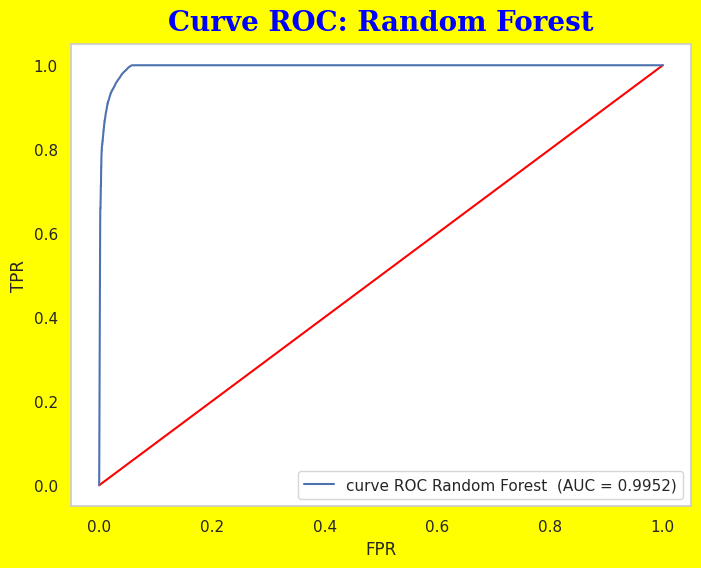

In [114]:
## Graphing our ROC curve
auc_roc_rf = roc_auc_score(y_test,y_proba_test_rf)
fpr, tpr, thresholds = roc_curve(y_test,y_proba_test_rf)
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")
plt.plot(fpr,fpr,color='red')
plt.plot(fpr,tpr,label=(f'curve ROC Random Forest  (AUC = {auc_roc_rf:.4f})'))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curve ROC: Random Forest',pad=10, fontdict={'fontsize': 20, 'fontfamily':'serif','fontstyle':'normal', 'fontweight': 'heavy', 'color': 'blue'})
plt.legend(loc = 'lower right')
plt.grid(False)
plt.gcf().set_facecolor('yellow')
plt.show()

In [115]:
# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Extract confusion matrix values
tn, fp, fn, tp = conf_matrix_rf.ravel()

# Calculate additional metrics
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# print them
print("confusion matrix:")
print(conf_matrix_rf)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

confusion matrix:
[[28431  1569]
 [  147 29853]]
False Positive Rate: 0.0523
False Negative Rate: 0.0049


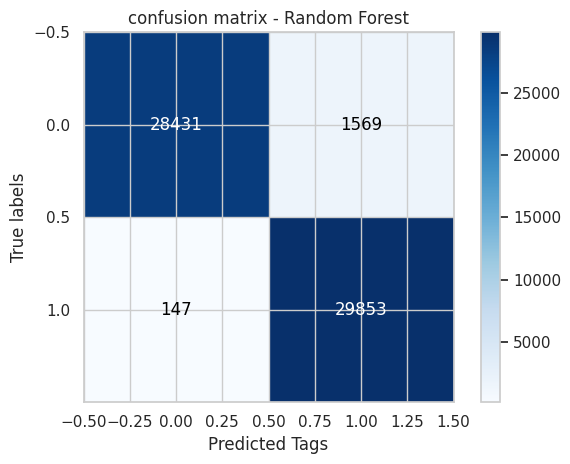

In [116]:

plt.imshow(conf_matrix_rf, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('confusion matrix - Random Forest')
plt.colorbar()
plt.xlabel('Predicted Tags')
plt.ylabel('True labels')


thresh = conf_matrix_rf.max() / 2.
for i in range(conf_matrix_rf.shape[0]):
    for j in range(conf_matrix_rf.shape[1]):
        plt.text(j, i, format(conf_matrix_rf[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix_rf[i, j] > thresh else "black")

plt.yticks(np.arange(-0.5, 1.5, 0.5))


plt.tight_layout()
plt.show()

In [117]:
## Evaluating overfitting of Random Forest
y_train_proba_rf = model_rf.predict_proba(x_train_scaled_rf)[:,1]
y_test_proba_rf = model_rf.predict_proba(x_test_scaled_rf)[:,1]

## Calculating AUC-ROC for Train y Test
train_auc_rf = roc_auc_score(y_train,y_train_proba_rf)
test_auc_rf = roc_auc_score(y_test,y_test_proba_rf)

print(f'train_auc_rf = {train_auc_rf}')
print(f'test_auc_rf = {test_auc_rf}' )
print('\n')

## Determinate if there overfitting
if train_auc_rf - test_auc_rf > 0.1:
  print('The model can be overfitting')
else:
  print('The model is not overfitting')

train_auc_rf = 0.9974373609722222
test_auc_rf = 0.9951852205555555


The model is not overfitting


<ipython-input-118-4a2ed2f9496c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


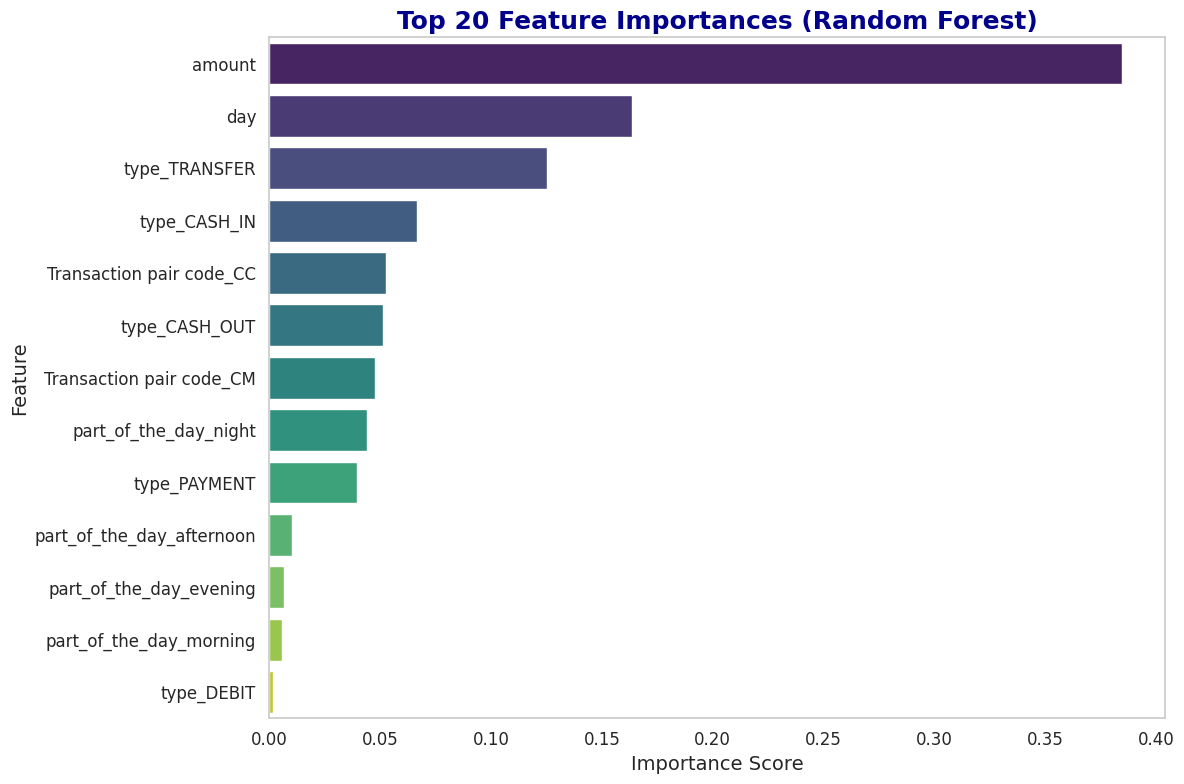

In [118]:
# Get feature importances from Random Forest
importances = model_rf.feature_importances_

# Create a DataFrame with feature names
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
})

# Sort and select top 20
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')

# Styling
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()

In [119]:
 joblib.dump(model_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

# **XGBoost**

In [120]:
pip install xgboost


In [121]:
n_estimators = [100, 200, 300]
max_depth = [None, 10, 20, 30]

for n in n_estimators:
    for m in max_depth:
        xgb_model = xgb.XGBClassifier(
            n_estimators=n,
            max_depth=m,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

        # Train the model
        xgb_model.fit(x_train_pca, y_train)

        # Predict
        y_pred = xgb_model.predict(x_test_pca)
        y_proba = xgb_model.predict_proba(x_test_pca)[:, 1]

        # Print metrics
        print(f"max_depth={m}, n_estimators={n}"
              f" -> Accuracy: {accuracy_score(y_test, y_pred):.4f}"
              f" | Precision: {precision_score(y_test, y_pred):.4f}"
              f" | Recall: {recall_score(y_test, y_pred):.4f}"
              f" | F1-score: {f1_score(y_test, y_pred):.4f}"
              f" | AUC: {roc_auc_score(y_test, y_proba):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:56:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=None, n_estimators=100 -> Accuracy: 0.9149 | Precision: 0.9017 | Recall: 0.9312 | F1-score: 0.9163 | AUC: 0.9760


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:56:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=10, n_estimators=100 -> Accuracy: 0.9456 | Precision: 0.9181 | Recall: 0.9785 | F1-score: 0.9473 | AUC: 0.9862


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=20, n_estimators=100 -> Accuracy: 0.9575 | Precision: 0.9285 | Recall: 0.9914 | F1-score: 0.9589 | AUC: 0.9905


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=30, n_estimators=100 -> Accuracy: 0.9581 | Precision: 0.9289 | Recall: 0.9921 | F1-score: 0.9595 | AUC: 0.9905


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=None, n_estimators=200 -> Accuracy: 0.9287 | Precision: 0.9104 | Recall: 0.9510 | F1-score: 0.9303 | AUC: 0.9811


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=10, n_estimators=200 -> Accuracy: 0.9533 | Precision: 0.9236 | Recall: 0.9884 | F1-score: 0.9549 | AUC: 0.9889


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=20, n_estimators=200 -> Accuracy: 0.9581 | Precision: 0.9289 | Recall: 0.9922 | F1-score: 0.9595 | AUC: 0.9906


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=30, n_estimators=200 -> Accuracy: 0.9585 | Precision: 0.9295 | Recall: 0.9922 | F1-score: 0.9598 | AUC: 0.9905


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=None, n_estimators=300 -> Accuracy: 0.9374 | Precision: 0.9150 | Recall: 0.9644 | F1-score: 0.9390 | AUC: 0.9840


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=10, n_estimators=300 -> Accuracy: 0.9556 | Precision: 0.9260 | Recall: 0.9904 | F1-score: 0.9571 | AUC: 0.9898


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:59:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=20, n_estimators=300 -> Accuracy: 0.9584 | Precision: 0.9293 | Recall: 0.9922 | F1-score: 0.9597 | AUC: 0.9906


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


max_depth=30, n_estimators=300 -> Accuracy: 0.9586 | Precision: 0.9298 | Recall: 0.9922 | F1-score: 0.9600 | AUC: 0.9905


In [122]:
# After reviewing the outputs
best_model_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=30,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)



In [123]:
# Train the model
best_model_xgb.fit(x_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:01:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [124]:

# Make predictions on the test set
y_pred_xgb = best_model_xgb.predict(x_test_pca)

y_proba_test_xgb = best_model_xgb.predict_proba(x_test_pca)[:,1]

In [125]:
# Evaluate performance
print(f"max_depth={30}, n_estimators={300} -> "
f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}, "
f"Precision: {precision_score(y_test, y_pred_xgb):.4f}, "
f"Recall: {recall_score(y_test, y_pred_xgb):.4f}, "
f"F1-score: {f1_score(y_test, y_pred_xgb):.4f}, "
f"AUC: {roc_auc_score(y_test, y_proba_test_xgb):.4f}")

max_depth=30, n_estimators=300 -> Accuracy: 0.9586, Precision: 0.9298, Recall: 0.9922, F1-score: 0.9600, AUC: 0.9905


In [126]:
# Generate the classification report for XGBoost
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["No Fraud", "Fraud"], output_dict=True)

# Convert the classification report to a DataFrame and apply background gradient
pd.DataFrame(report_xgb).style.background_gradient(cmap='Blues')

,No Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.991638,0.929752,0.958617,0.960695,0.960695
recall,0.925033,0.992200,0.958617,0.958617,0.958617
f1-score,0.957179,0.959961,0.958617,0.958570,0.958570
support,30000.000000,30000.000000,0.958617,60000.000000,60000.000000


In [127]:

# Compute FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test_xgb)

# Compute Youden's J statistic
youden_j = tpr - fpr
best_index = youden_j.argmax()
best_threshold = thresholds[best_index]

print(f"Best Threshold (Youden's J): {best_threshold:.4f}")
print(f"TPR at Best Threshold: {tpr[best_index]:.4f}")
print(f"FPR at Best Threshold: {fpr[best_index]:.4f}")

Best Threshold (Youden's J): 0.4687
TPR at Best Threshold: 0.9953
FPR at Best Threshold: 0.0777


In [128]:
# Custom thresholding for XGBoost
custom_threshold = 0.4687
  # You can adjust this

# Convert XGBoost probabilities to class labels using the custom threshold
y_pred_thresh_xgb = (y_proba_test_xgb >= custom_threshold).astype(int)

# Recalculate metrics using the thresholded predictions
accuracy_thresh = accuracy_score(y_test, y_pred_thresh_xgb)
precision_thresh = precision_score(y_test, y_pred_thresh_xgb)
recall_thresh = recall_score(y_test, y_pred_thresh_xgb)
f1_thresh = f1_score(y_test, y_pred_thresh_xgb)
roc_auc_thresh = roc_auc_score(y_test, y_proba_test_xgb)  # AUC stays the same

# Print results
print("\n--- Metrics with Custom Threshold (XGBoost) ---")
print(f"Threshold: {custom_threshold}")
print(f"Accuracy: {accuracy_thresh:.4f}")
print(f"Precision: {precision_thresh:.4f}")
print(f"Recall: {recall_thresh:.4f}")
print(f"F1-score: {f1_thresh:.4f}")
print(f"AUC: {roc_auc_thresh:.4f}")



--- Metrics with Custom Threshold (XGBoost) ---
Threshold: 0.4687
Accuracy: 0.9588
Precision: 0.9276
Recall: 0.9953
F1-score: 0.9603
AUC: 0.9905


In [129]:
## In this case, we know that class 0 - No fraud and class 1 - fraud
## We calculate the metrics for class 1
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = report_xgb['Fraud']['precision']
recall_xgb = report_xgb['Fraud']['recall']
f1_xgb = report_xgb['Fraud']['f1-score']
auc_roc_xgb = roc_auc_score(y_test,y_proba_test_xgb)
metricas_xgb = []
metricas_xgb.extend([accuracy_xgb,precision_xgb,recall_xgb,f1_xgb,auc_roc_xgb])
print('Accuracy:', accuracy_xgb)
print('Precision:',precision_xgb)
print('Recall:', recall_xgb)
print('F1-score:',f1_xgb)
print('AUC-ROC:',auc_roc_xgb)

Accuracy: 0.9586166666666667
Precision: 0.9297516789005154
Recall: 0.9922
F1-score: 0.95996129968556
AUC-ROC: 0.9904958572222222


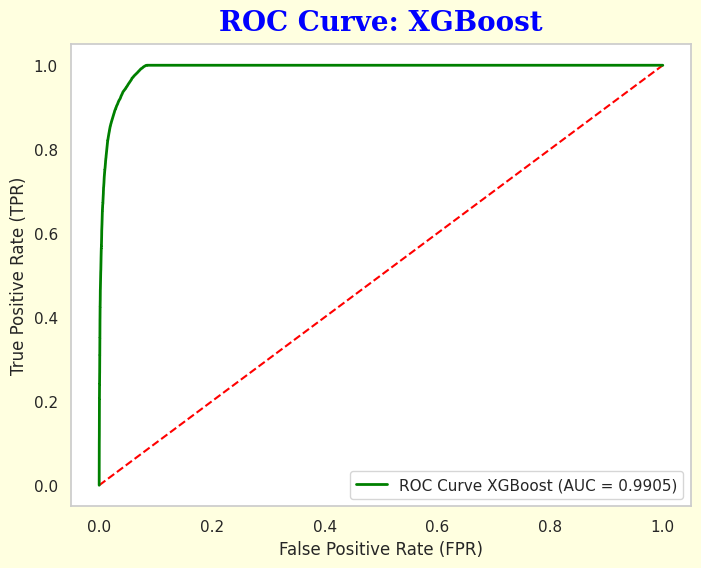

In [130]:
# Calculate AUC and ROC curve values for XGBoost
auc_roc_xgb = roc_auc_score(y_test, y_proba_test_xgb)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_test_xgb)

# Plot the ROC curve for XGBoost
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Diagonal line (random classifier)
plt.plot(fpr_xgb, fpr_xgb, color='red', linestyle='--')

# ROC Curve
plt.plot(fpr_xgb, tpr_xgb, label=f'ROC Curve XGBoost (AUC = {auc_roc_xgb:.4f})', color='green', linewidth=2)

# Labels and Title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: XGBoost', pad=10, fontdict={
    'fontsize': 20,
    'fontfamily': 'serif',
    'fontstyle': 'normal',
    'fontweight': 'heavy',
    'color': 'blue'
})

plt.legend(loc='lower right')
plt.grid(False)
plt.gcf().set_facecolor('lightyellow')
plt.show()

In [131]:
# Calculate confusion matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test,  y_pred_xgb)

# Extract values
tn, fp, fn, tp = conf_matrix_xgb.ravel()

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Print results
print("Confusion Matrix (XGBoost with Custom Threshold):")
print(conf_matrix_xgb)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

Confusion Matrix (XGBoost with Custom Threshold):
[[27751  2249]
 [  234 29766]]
False Positive Rate: 0.07496666666666667
False Negative Rate: 0.0078


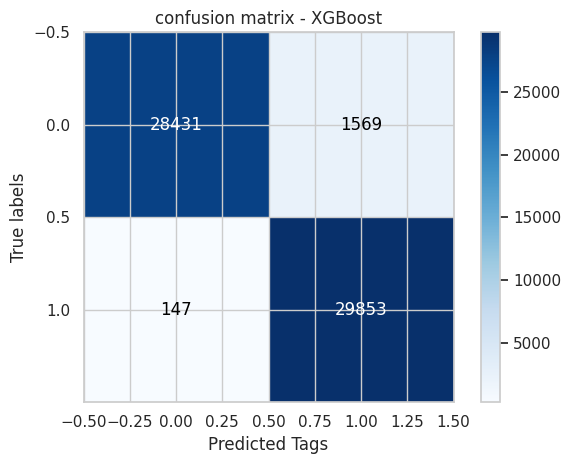

In [132]:
plt.imshow(conf_matrix_xgb, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('confusion matrix - XGBoost')
plt.colorbar()
plt.xlabel('Predicted Tags')
plt.ylabel('True labels')


thresh = conf_matrix_rf.max() / 2.
for i in range(conf_matrix_rf.shape[0]):
    for j in range(conf_matrix_rf.shape[1]):
        plt.text(j, i, format(conf_matrix_rf[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix_rf[i, j] > thresh else "black")

plt.yticks(np.arange(-0.5, 1.5, 0.5))


plt.tight_layout()
plt.show()

In [133]:
joblib.dump(xgb_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

***Hyperparameters tuning***

<ipython-input-134-76026834055d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


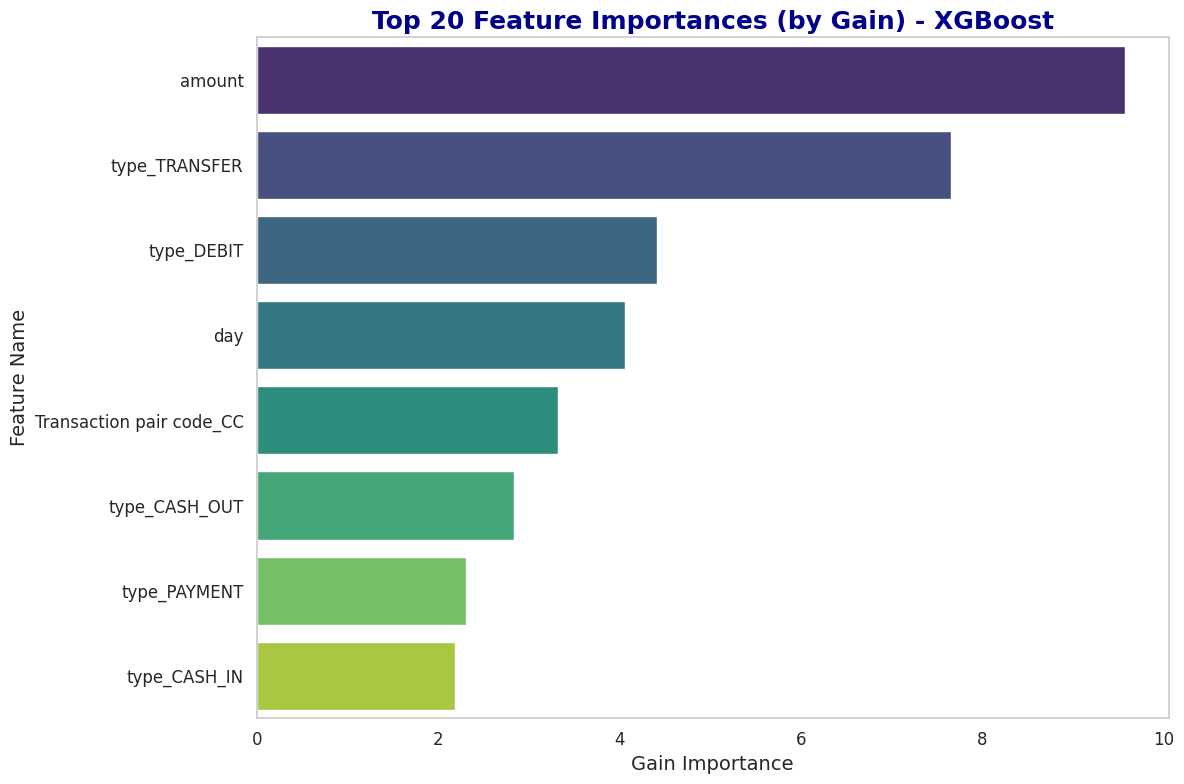

In [134]:
# Get feature importances with real feature names
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and map real names
feature_importance_df = pd.DataFrame({
    'Feature': [x_train.columns[int(f[1:])] for f in feature_importance.keys()],
    'Importance': list(feature_importance.values())
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')

# Styling
plt.title('Top 20 Feature Importances (by Gain) - XGBoost', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Gain Importance', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()


# **Models combination**

In [135]:
# Probabilities for TRAIN set
y_proba_train_rf = model_rf.predict_proba(x_train_scaled_rf)[:, 1]
y_proba_train_xgb = best_model_xgb.predict_proba(x_train_pca)[:, 1]

In [136]:
# Reshape to column vectors
rf_train_col = y_proba_train_rf.reshape(-1, 1)
rf_test_col = y_proba_test_rf.reshape(-1, 1)
xgb_train_col = y_proba_train_xgb.reshape(-1, 1)
xgb_test_col = y_proba_test_xgb.reshape(-1, 1)

# Choose a base input — either scaled or PCA-reduced version
base_x_train = x_train_pca  # or x_train_pca if you used PCA
base_x_test = x_test_pca

# Create hybrid inputs
x_train_hybrid = np.hstack((base_x_train, rf_train_col, xgb_train_col))
x_test_hybrid = np.hstack((base_x_test, rf_test_col, xgb_test_col))

# **CNN**

In [137]:
# 3. Reshape for CNN input
x_train_cnn =x_train_hybrid.reshape(-1, x_train_hybrid.shape[1], 1)
x_test_cnn = x_test_hybrid.reshape(-1, x_test_hybrid.shape[1], 1)


In [138]:

# 4. Define the CNN model
model_cnn = Sequential([
    Input(shape=(x_train_cnn.shape[1], 1)),

    # Convolutional Block 1
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    SpatialDropout1D(0.2),
    MaxPooling1D(pool_size=2),

    # Convolutional Block 2
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    MaxPooling1D(pool_size=2),

    # Convolutional Block 3
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(1, activation='sigmoid')
])

# 5. Compile the model
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

# 6. Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
model_cnn.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 10, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 5, 128)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,041 (715.00 KB)

 Trainable params: 182,145 (711.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [139]:
# 7. Train the model
history_cnn = model_cnn.fit(
    x_train_cnn, y_train,
    validation_data=(x_test_cnn, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/30
7500/7500 - 122s - 16ms/step - AUC: 0.9955 - Precision: 0.9542 - Recall: 0.9945 - accuracy: 0.9734 - loss: 0.0687 - val_AUC: 0.9914 - val_Precision: 0.9457 - val_Recall: 1.0000 - val_accuracy: 0.9713 - val_loss: 0.0978
Epoch 2/30
7500/7500 - 138s - 18ms/step - AUC: 0.9965 - Precision: 0.9548 - Recall: 0.9975 - accuracy: 0.9751 - loss: 0.0607 - val_AUC: 0.9918 - val_Precision: 0.9457 - val_Recall: 1.0000 - val_accuracy: 0.9713 - val_loss: 0.1029
Epoch 3/30
7500/7500 - 141s - 19ms/step - AUC: 0.9967 - Precision: 0.9548 - Recall: 0.9975 - accuracy: 0.9752 - loss: 0.0597 - val_AUC: 0.9922 - val_Precision: 0.9470 - val_Recall: 0.9999 - val_accuracy: 0.9720 - val_loss: 0.0923
Epoch 4/30
7500/7500 - 147s - 20ms/step - AUC: 0.9968 - Precision: 0.9555 - Recall: 0.9971 - accuracy: 0.9754 - loss: 0.0586 - val_AUC: 0.9918 - val_Precision: 0.9468 - val_Recall: 1.0000 - val_accuracy: 0.9719 - val_loss: 0.1077
Epoch 5/30
7500/7500 - 145s - 19ms/step - AUC: 0.9968 - Precision: 0.9552 - Reca

In [140]:
# 1. Predict probabilities and class labels
y_proba_cnn = model_cnn.predict(x_test_cnn).ravel()  # Probabilities
y_pred_cnn = (y_proba_cnn >= 0.5).astype(int)        # Binary predictions



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [141]:
# 2. Classification report
# Generate the classification report for XGBoost
report_cnn = classification_report(y_test, y_pred_cnn, target_names=["No Fraud", "Fraud"], output_dict=True)
pd.DataFrame(report_cnn).style.background_gradient(cmap='Blues')

,No Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999929,0.946966,0.971967,0.973448,0.973448
recall,0.944000,0.999933,0.971967,0.971967,0.971967
f1-score,0.971160,0.972729,0.971967,0.971945,0.971945
support,30000.000000,30000.000000,0.971967,60000.000000,60000.000000


In [142]:
# Compute FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba_cnn)

# Compute Youden's J statistic
youden_j = tpr - fpr
best_index = youden_j.argmax()
best_threshold = thresholds[best_index]

print(f"Best Threshold (Youden's J): {best_threshold:.4f}")
print(f"TPR at Best Threshold: {tpr[best_index]:.4f}")
print(f"FPR at Best Threshold: {fpr[best_index]:.4f}")

Best Threshold (Youden's J): 0.5691
TPR at Best Threshold: 0.9961
FPR at Best Threshold: 0.0510


In [143]:
# Custom thresholding for CNN
custom_threshold = 0.5691
  # You can adjust this

# Convert CNN probabilities to class labels using the custom threshold
y_pred_thresh_cnn = (y_proba_cnn >= custom_threshold).astype(int)

# Recalculate metrics using the thresholded predictions
accuracy_thresh = accuracy_score(y_test, y_pred_thresh_cnn)
precision_thresh = precision_score(y_test, y_pred_thresh_cnn)
recall_thresh = recall_score(y_test, y_pred_thresh_cnn)
f1_thresh = f1_score(y_test, y_pred_thresh_cnn)
roc_auc_thresh = roc_auc_score(y_test, y_proba_cnn)  # AUC stays the same

# Print results
print("\n--- Metrics with Custom Threshold (XGBoost) ---")
print(f"Threshold: {custom_threshold}")
print(f"Accuracy: {accuracy_thresh:.4f}")
print(f"Precision: {precision_thresh:.4f}")
print(f"Recall: {recall_thresh:.4f}")
print(f"F1-score: {f1_thresh:.4f}")
print(f"AUC: {roc_auc_thresh:.4f}")


--- Metrics with Custom Threshold (XGBoost) ---
Threshold: 0.5691
Accuracy: 0.9724
Precision: 0.9519
Recall: 0.9950
F1-score: 0.9730
AUC: 0.9925


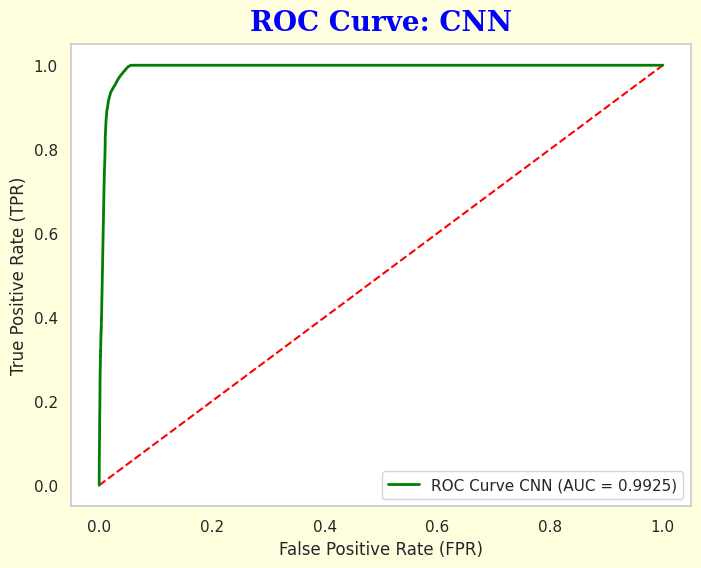

In [144]:
# Calculate AUC and ROC curve values for CNN
auc_roc_cnn = roc_auc_score(y_test, y_proba_cnn)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_proba_cnn)

# Plot the ROC curve for CNN
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Diagonal line (random classifier)
plt.plot(fpr_xgb, fpr_xgb, color='red', linestyle='--')

# ROC Curve
plt.plot(fpr_cnn, tpr_cnn, label=f'ROC Curve CNN (AUC = {auc_roc_cnn:.4f})', color='green', linewidth=2)

# Labels and Title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: CNN', pad=10, fontdict={
    'fontsize': 20,
    'fontfamily': 'serif',
    'fontstyle': 'normal',
    'fontweight': 'heavy',
    'color': 'blue'
})

plt.legend(loc='lower right')
plt.grid(False)
plt.gcf().set_facecolor('lightyellow')
plt.show()

In [ ]:
# Calculate confusion matrix for CNN
conf_matrix_cnn = confusion_matrix(y_test,  y_pred_cnn)

# Extract values
tn, fp, fn, tp = conf_matrix_cnn.ravel()

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Print results
print("Confusion Matrix (CNN with Custom Threshold):")
print(conf_matrix_cnn)
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

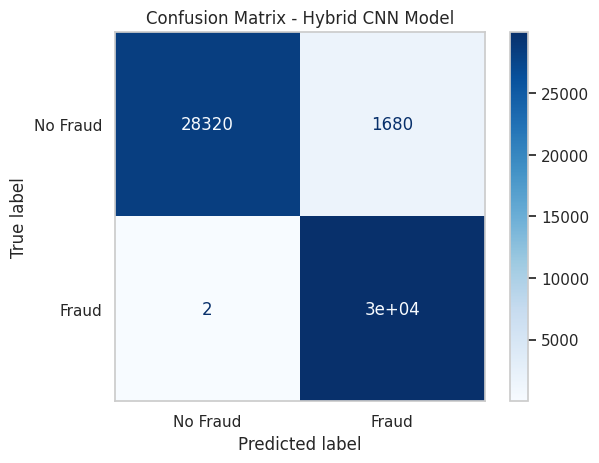

In [145]:
# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Hybrid CNN Model")
plt.grid(False)
plt.show()

In [146]:
model_cnn.save("cnn_model.h5")

In [147]:
# --- Assuming you already have these predicted probabilities ---
# proba_rf   : RF probabilities on test set (shape: [n_samples])
# proba_xgb  : XGB probabilities on test set (shape: [n_samples])
# proba_cnn  : CNN probabilities on test set (shape: [n_samples])

# Make sure all are 1D arrays
proba_rf = y_proba_test_rf.flatten()
proba_xgb = y_proba_test_xgb.flatten()
proba_cnn = y_proba_cnn.flatten()

# Combine predictions using weighted average
combined_proba = (0.3 * proba_rf) + (0.2 * proba_xgb) + (0.5 * proba_cnn)

# Get final predictions (binary)
final_preds = (combined_proba >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("Ensemble Accuracy:", accuracy_score(y_test, final_preds))
print("Ensemble AUC:", roc_auc_score(y_test, combined_proba))
# 2. Classification report
# Generate classification report
report_ensemble = classification_report(
    y_test,
    final_preds,
    target_names=["No Fraud", "Fraud"],
    output_dict=True
)

# Convert to DataFrame
report_df = pd.DataFrame(report_ensemble)

# Round all values except the 'f1-score' row in 'No Fraud' and 'Fraud' columns
for col in ['No Fraud', 'Fraud']:
    report_df.loc[report_df.index != 'f1-score', col] = report_df.loc[report_df.index != 'f1-score', col].round(2)

# Apply gradient styling only to 'No Fraud' and 'Fraud' columns
styled_report = report_df.style.background_gradient(subset=['No Fraud', 'Fraud'], cmap='Blues')

styled_report


Ensemble Accuracy: 0.9723
Ensemble AUC: 0.9943934577777778


,No Fraud,Fraud,accuracy,macro avg,weighted avg
precision,1.000000,0.950000,0.972300,0.973617,0.973617
recall,0.950000,1.000000,0.972300,0.972300,0.972300
f1-score,0.971550,0.973012,0.972300,0.972281,0.972281
support,30000.000000,30000.000000,0.972300,60000.000000,60000.000000


In [148]:
# Load your trained models
rf_model = joblib.load("random_forest_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")
cnn_model = load_model("cnn_model.h5")
# Load trained scalers
scaler_rf = joblib.load('/content/scaler_rf.pkl')
scaler = joblib.load('/content/scaler.pkl')
pca = joblib.load("/content/pca_model.pkl")




In [ ]:
!pip install flask_ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 2wzmITfYB3YCFM5TmbX0Wdvrrah_4b5VRpP23WSci7sD6TDkF

In [ ]:
!pip install flask-ngrok pyngrok --quiet
!wget -q -O ngrok.zip https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.zip
!unzip -o ngrok.zip
!chmod +x ngrok



In [ ]:
!./ngrok config add-authtoken 2wzmITfYB3YCFM5TmbX0Wdvrrah_4b5VRpP23WSci7sD6TDkF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install Flask joblib tensorflow xgboost


In [ ]:
!pip install flask flask-ngrok joblib requests

In [ ]:
!wget -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -n ngrok-stable-linux-amd64.zip

In [ ]:
!./ngrok config add-authtoken 2wzmITfYB3YCFM5TmbX0Wdvrrah_4b5VRpP23WSci7sD6TDkF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# ✅ FLASK COLAB API
import joblib
import numpy as np
import tensorflow as tf
from flask import Flask, request, jsonify
import threading
import subprocess
import requests
import time

# 🔁 Load models
rf_model = joblib.load("random_forest_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")
cnn_model = tf.keras.models.load_model("cnn_model.h5")

# 🔁 Load preprocessing tools
scaler = joblib.load("scaler.pkl")
scaler_rf = joblib.load("scaler_rf.pkl")
pca = joblib.load("pca_model.pkl")

# ✅ Flask App
app = Flask(__name__)

@app.route("/")
def index():
    return "✅ ML Flask API is live!"

@app.route("/predict", methods=["POST"])
def predict():
    try:
        data = request.get_json()
        features = np.array(data["features"]).reshape(1, -1)

        # 🔁 Apply preprocessing (NO MANUAL DROPPING)
        features_scaled_rf = scaler_rf.transform(features)
        features_scaled = scaler.transform(features)
        features_pca = pca.transform(features_scaled)

        # Combine for CNN
        combined = np.hstack((features_scaled_rf, features_pca))
        cnn_input = combined.reshape(1, combined.shape[1], 1)

        # 🔁 Predictions
        rf_pred = rf_model.predict(features_scaled_rf)[0]
        xgb_pred = xgb_model.predict(features_pca)[0]
        cnn_pred = np.argmax(cnn_model.predict(cnn_input), axis=1)[0]

        final_pred = max(set([rf_pred, xgb_pred, cnn_pred]), key=[rf_pred, xgb_pred, cnn_pred].count)

        return jsonify({
            "rf_pred": int(rf_pred),
            "xgb_pred": int(xgb_pred),
            "cnn_pred": int(cnn_pred),
            "final_prediction": int(final_pred)
        })

    except Exception as e:
        return jsonify({"error": str(e)})

# ✅ Start ngrok + server
def start_ngrok():
    subprocess.Popen(['./ngrok', 'http', '5000'])

threading.Thread(target=start_ngrok).start()
threading.Thread(target=lambda: app.run(port=5000)).start()

# ✅ Get public URL
time.sleep(4)
try:
    tunnels = requests.get("http://localhost:4040/api/tunnels").json()
    for tunnel in tunnels["tunnels"]:
        print("🔗 Public URL:", tunnel["public_url"])
except:
    print("❌ Could not fetch ngrok URL.")


In [ ]:
import requests

# ✅ Replace with your actual ngrok public URL
url = "https://e8fe-34-16-218-94.ngrok-free.app/predict"

# ✅ Replace this with 13 actual float values from your dataset
payload = {
    "features": [0.5, 1.2, 3.1, 4.2, 5.3, 6.4, 7.5, 8.6, 9.7, 10.8, 11.9, 12.0, 13.4]
}

# Send request to your Flask API
response = requests.post(url, json=payload)

# Print the result
print("Status Code:", response.status_code)
print("Response:", response.json())


In [ ]:
fraud_sample = df[df['isFraud'] == 1].iloc[0]
print(fraud_sample.values)

In [ ]:
# Find first fraud sample
fraud_sample = df[df["isFraud"] == 1].iloc[0]
features = fraud_sample.drop("isFraud").values.tolist()

print("Fraud sample features:", features)

In [ ]:
import requests

url = "https://e8fe-34-16-218-94.ngrok-free.app/predict"

payload = {
    "features": [181.0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
}

response = requests.post(url, json=payload)
print("Status Code:", response.status_code)
print("Response:", response.json())


In [ ]:
# Test the API request (example using requests library)
url = "https://e8fe-34-16-218-94.ngrok-free.app/predict"  # Replace with your public ngrok URL

payload = {
    "features": [181.0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]  # Replace with actual feature values
}

response = requests.post(url, json=payload)
print("Status Code:", response.status_code)
print("Response:", response.json())